# Classification non supervisée
	

## Classification Ascendante Hiérarchique (CHA) : dendrogramme
	

## Kmeans


## Objectif : construction d'un dendrogramme contenant l'ensemble des pays étudiés, puis découpage afin d'obtenir 5 groupes

## Sommaire

 - [Importation des librairies](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Importation-des-librairies)
 - [Téléchargement et lecture du dataframe](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#T%C3%A9l%C3%A9chargement-et-lecture-du-dataframe)
 - [Standardisation des données](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Standardisation-des-donn%C3%A9es)
 - [Réalisation du dendrogramme](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#R%C3%A9alisation-du-dendrogramme)
 - [Découpage du dendrogramme en 5 groupes](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#D%C3%A9coupage-du-dendrogramme-en-5-groupes)
 - [Visualisation des différents groupes](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Visualisation-des-diff%C3%A9rents-groupes)
 - [Listes des différents groupes](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Listes-des-diff%C3%A9rents-groupes)
 - [Visualisation des centroïdes](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Visualisation-avec-les-centro%C3%AFdes)
 - [Tests d'adéquation](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Tests-d'ad%C3%A9quation)
 - [Tests de normalité](http://localhost:8888/notebooks/Documents/1produisez_etude_de_marche/dendrogramme.ipynb#Tests-de-normalit%C3%A9)
 

#### Importation des librairies

In [1]:
# importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  librairies pour le dendrogramme, Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage,  fcluster, centroid
from scipy.spatial.distance import pdist
from sklearn import decomposition
from yellowbrick.cluster import KElbowVisualizer

# librairies poour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
# from functions import *

# librairies pour les tests
from scipy.stats import ks_2samp
import scipy.stats as st
from scipy.stats import levene




In [2]:
ENCODAGE = 'UTF-8'

In [3]:
sns.set(style="darkgrid")

In [4]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,7))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="#FC4E07")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="#f6021c", alpha=0.8)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='#3751f5')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)      



In [5]:
# # Cercle des corrélations
# pcs = model.components_
# display_circles(pcs, n_comp, model, [(0,1)], labels = np.array(features))

In [6]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
             
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,7))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


In [7]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(7,7))
    plt.bar(np.arange(len(scree))+1, scree, color="#ff3f33")
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="#0c8ef4",marker='o')
    plt.xlabel("rang de l'axe d'inertie", size=12)
    plt.ylabel("pourcentage d'inertie", size=12)
    plt.title("Eboulis des valeurs propres", size=14)
    plt.show(block=False)

#### Téléchargement et lecture du dataframe

In [8]:
df_pop_dispo_alim = pd.read_csv('df_pop_dispo_alim.csv', encoding=ENCODAGE).copy()

In [9]:
df_pop_dispo_alim.head(2)

,pays,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
0,Arménie,-1.943347,2924.0,90.06,0.480124
1,Afghanistan,32.168195,2087.0,58.26,0.209578


In [10]:
df_pop_dispo_alim.shape


(174, 5)

In [11]:
df_paysIndex = df_pop_dispo_alim.set_index(['pays'])

In [12]:
df_paysIndex.head()

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,
Arménie,-1.943347,2924.0,90.06,0.480124
Afghanistan,32.168195,2087.0,58.26,0.209578
Albanie,-2.037666,3188.0,111.37,0.533447
Algérie,18.801321,3293.0,91.92,0.271758
Angola,39.238700,2474.0,57.27,0.321285


#### Tendances sur les différentes variables 

In [13]:
# df_variable_tendance = df_paysIndex

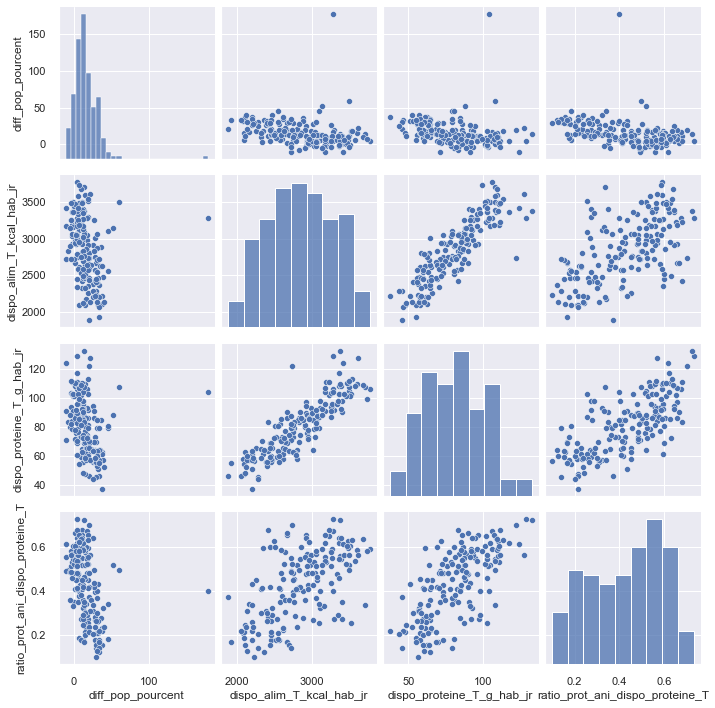

In [14]:
# kind="reg" || diag_kind="kde"
sns.pairplot(df_paysIndex)

Interprétation sommaire
- Présence d'un outlier 
- Disponibilité alim totale/dispo proteine totale : apparente corrélation positive
- Disponibilités alim totale en protéine et en kcal suivent une loi normale ?

In [15]:
features=df_paysIndex.columns
features

Index(['diff_pop_pourcent', 'dispo_alim_T_kcal_hab_jr',
       'dispo_proteine_T_g_hab_jr', 'ratio_prot_ani_dispo_proteine_T'],
      dtype='object')

In [16]:
df_paysIndex.shape

(174, 4)

#### Standardisation des données

In [17]:
# préparation des données pour le clustering
X = df_paysIndex.values
names = df_paysIndex.index

In [18]:
#  Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Calcul de la distance entre chaque échantillon 
Z = linkage(X_scaled,method='ward',metric='euclidean')

#### Réalisation du dendrogramme (variables toutes quantitatives)

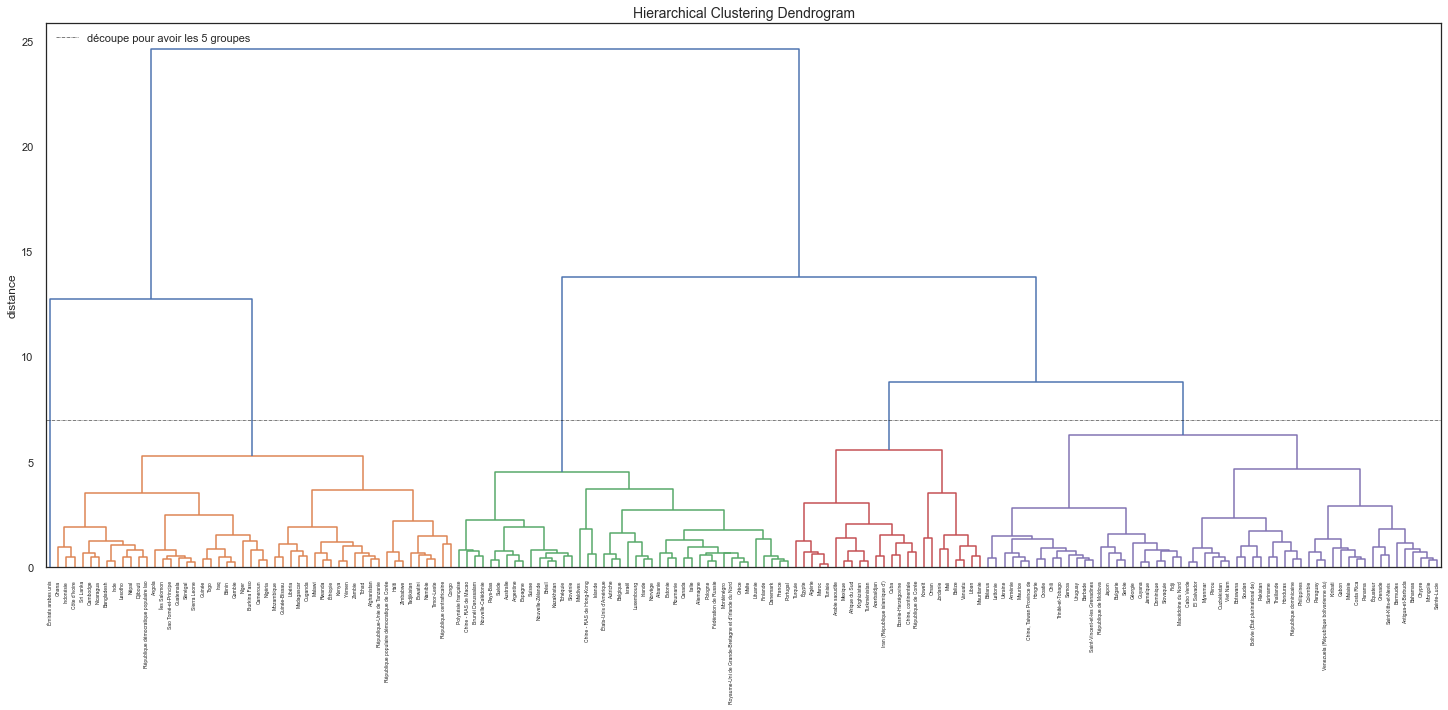

In [20]:
#affichage du dendrogramme
sns.set_style("white")
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Dendrogram", size=14)

dendrogram(Z,labels=names,orientation='top',
      color_threshold=7)
# plt.axvline(x=7, c='black',linestyle='dashdot', lw=0.5, label='découpe pour avoir les 5 groupes')
plt.axhline(y=7, c='black',linestyle='dashdot', lw=0.5, label='découpe pour avoir les 5 groupes') 
plt.ylabel('distance', size=12)
plt.legend(loc='upper left')
plt.savefig("P5_01_dendogramme.jpg")
plt.show()

#### Découpage du dendrogramme en 5 groupes

In [21]:
# 'maxclust' pour avoir le découpage en fonction du nb de clusters voulus => array des gpes clusters
# from sklearn.cluster import AgglomerativeClustering
# hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage= 'ward')
groupes_cah = fcluster(Z, t=5, criterion='maxclust')
print(groupes_cah)

[5 1 3 4 1 5 3 3 3 5 5 1 5 5 5 3 4 1 3 5 5 1 3 5 1 1 1 5 4 5 1 5 4 5 4 1 3
 5 5 5 5 4 5 3 5 3 3 3 1 5 5 1 3 4 1 5 3 5 1 1 5 1 5 3 5 5 3 1 1 4 1 3 3 3
 1 3 5 5 4 4 1 1 1 4 4 5 1 4 1 1 3 3 1 1 5 3 4 3 4 5 4 5 4 1 5 1 1 3 3 5 4
 3 1 1 1 3 5 5 3 5 5 5 3 3 1 1 1 3 1 3 5 5 5 1 4 1 1 3 5 4 3 5 1 1 3 3 4 5
 1 5 1 5 4 4 4 2 1 3 5 3 1 5 5 5 5 1 5 1 1 3 3 5 3 5]


In [22]:
print(np.unique(groupes_cah).size, "groupes sont constitués")

5 groupes sont constitués


In [23]:
df_classes = pd.DataFrame({'clusters': groupes_cah, 'pays': names })
df_classes = df_classes.sort_values('clusters')

In [24]:
df_classes[df_classes['clusters']==5].sort_values(by='pays').pays.values


array(['Antigua-et-Barbuda', 'Arménie', 'Bahamas', 'Barbade', 'Bermudes',
       'Bolivie (État plurinational de)', 'Botswana', 'Bulgarie',
       'Bélarus', 'Cabo Verde', 'Chili', 'Chine, Taiwan Province de',
       'Chypre', 'Colombie', 'Costa Rica', 'Croatie', 'Dominique',
       'El Salvador', 'Fidji', 'Gabon', 'Grenade', 'Guyana', 'Géorgie',
       'Honduras', 'Hongrie', 'Jamaïque', 'Japon', 'Kiribati', 'Lettonie',
       'Macédoine du Nord', 'Malaisie', 'Maurice', 'Mongolie', 'Myanmar',
       'Ouzbékistan', 'Pakistan', 'Panama', 'Paraguay', 'Philippines',
       'Pérou', 'République de Moldova', 'République dominicaine',
       'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines',
       'Sainte-Lucie', 'Samoa', 'Serbie', 'Slovaquie', 'Soudan',
       'Suriname', 'Thaïlande', 'Trinité-et-Tobago', 'Ukraine', 'Uruguay',
       'Venezuela (République bolivarienne du)', 'Viet Nam', 'Équateur'],
      dtype=object)

In [25]:
df_un  = df_classes[df_classes['clusters']==5]

#### Visualisation des différents groupes

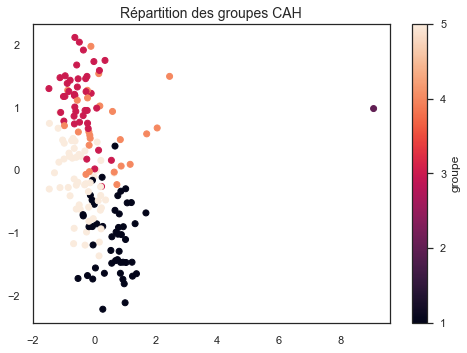

In [26]:
# Sur les 2 premières variables
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=groupes_cah)
plt.colorbar(ticks=range(6), label='groupe')
plt.title("Répartition des groupes CAH", size=14)
plt.savefig("Répartition des groupes CAH.jpg")
plt.show()

#### Remarque
- présence d'un outlier : groupe 2
- groupe 1, 3 et 5 plutôt bien concentrés
- groupe 4 dispersé

#### Identification des différents groupes

In [27]:
#tri des index des groupes => pour avoir les index des pays (ex df.index[86])
idg = np.argsort(groupes_cah)

In [28]:
#affichage des observations et leurs groupes
df_clusters = pd.DataFrame(df_paysIndex.index[idg],groupes_cah[idg])
df_clusters

,pays
1,République démocratique populaire lao
1,Népal
1,Namibie
1,Mozambique
1,Ouganda
...,...
5,Guyana
5,Grenade
5,Kiribati
5,Lettonie


#### Export de la liste des pays ainsi que (pour chacun d'entre eux) de leur groupe  après découpe du dendrogramme

In [29]:
# Export de la liste des pays en csv
df_clusters.to_csv("P5_03_liste_pays_gpe_dendrogramme.csv", index = True)

In [30]:
# dataframe regroupant les pays par groupe
df_dispo_gpe = df_paysIndex.iloc[idg].copy()

In [31]:
# Création d'une colonne 'groupe'
df_dispo_gpe['groupe'] = groupes_cah[idg]

In [32]:
# Export de la liste des pays en csv
df_dispo_gpe.to_csv("P5_03_liste_pays_dendrog.csv", index = False)

In [33]:
df_dispo_gpe.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
Népal,13.336867,2672.0,68.99,0.165966,1


In [34]:
# Regroupement des pays en fonction de leur cluster (groupe) et moyenne des variables
df_dispo_gpe_mean = df_dispo_gpe.groupby(['groupe']).agg({'diff_pop_pourcent':'mean','dispo_alim_T_kcal_hab_jr':'mean', 'dispo_proteine_T_g_hab_jr':'mean',
                                   'ratio_prot_ani_dispo_proteine_T':'mean'})

In [35]:
df_dispo_gpe_mean

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
groupe,,,,
1,25.835183,2379.680000,59.306800,0.229238
2,177.411695,3275.000000,104.510000,0.399005
3,7.514480,3333.928571,106.417381,0.600161
4,20.689606,3150.375000,90.214167,0.372324
5,7.835139,2764.017544,77.922982,0.498493


In [36]:
df_dispo_gpe_mean_resIndex = df_dispo_gpe_mean.reset_index()

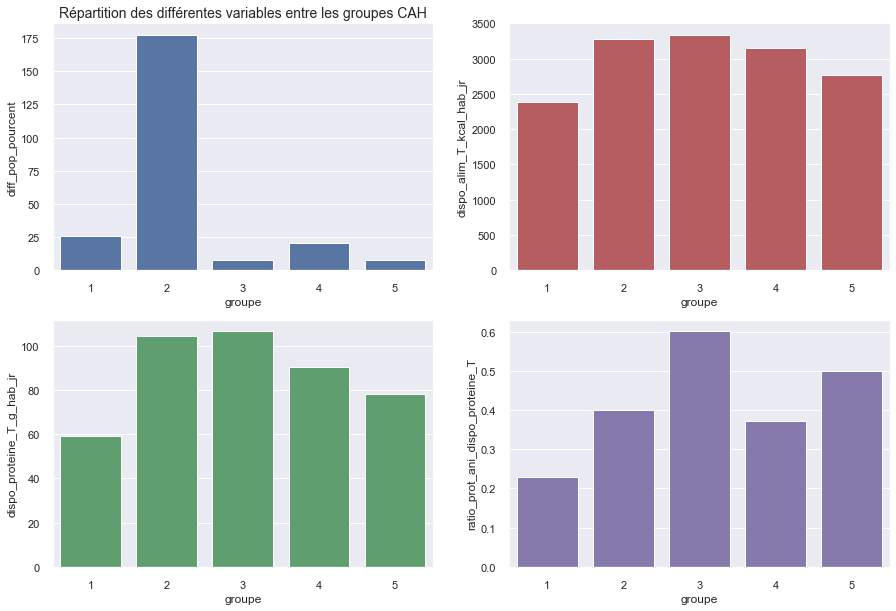

In [37]:
# Visualisation de la répartition des variables entre les groupes de pays
sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1.set_title("Répartition des différentes variables entre les groupes CAH", size=14)
# plt.title("Répartition entre les différents groupes CAH", size=12)
sns.barplot(data=df_dispo_gpe_mean_resIndex, x='groupe', y='diff_pop_pourcent',  color='b', ax=ax1)
sns.barplot(data=df_dispo_gpe_mean_resIndex, x='groupe', y='dispo_alim_T_kcal_hab_jr',  color='r', ax=ax2)
sns.barplot(data=df_dispo_gpe_mean_resIndex, x='groupe', y='dispo_proteine_T_g_hab_jr', color='g', ax=ax3)
sns.barplot(data=df_dispo_gpe_mean_resIndex, x='groupe', y='ratio_prot_ani_dispo_proteine_T', color='m', ax=ax4)
plt.savefig("Répartition des différentes variables entre les groupes CAH.jpg")
plt.show()

In [38]:
# moyenne par variable
m = df_paysIndex.mean()
m

diff_pop_pourcent                    15.677773
dispo_alim_T_kcal_hab_jr           2847.367816
dispo_proteine_T_g_hab_jr            81.299598
ratio_prot_ani_dispo_proteine_T       0.427687
dtype: float64

In [39]:
# Somme totale des carrés (variabilité totale) Total Sum of Squares
TSS = df_paysIndex.shape[0]*df_paysIndex.var(ddof=0)
TSS

diff_pop_pourcent                  5.517197e+04
dispo_alim_T_kcal_hab_jr           3.327195e+07
dispo_proteine_T_g_hab_jr          6.895506e+04
ratio_prot_ani_dispo_proteine_T    4.513957e+00
dtype: float64

In [40]:
# Regroupement par groupes CAH
gb = df_paysIndex.groupby(groupes_cah)
gb

In [41]:
# Effectif conditionel groupes CAH
nk = gb.size()
nk

1    50
2     1
3    42
4    24
5    57
dtype: int64

In [42]:
# moyennes conditionnelles (intraclasse)
mk = gb.mean()
mk

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
1,25.835183,2379.680000,59.306800,0.229238
2,177.411695,3275.000000,104.510000,0.399005
3,7.514480,3333.928571,106.417381,0.600161
4,20.689606,3150.375000,90.214167,0.372324
5,7.835139,2764.017544,77.922982,0.498493


In [43]:
# Pour chaque groupe CAH : écart à la moyenne par variable (interclasse)
EMk= (mk-m)**2
EMk

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
1,103.172981,218731.893321,483.683151,0.039382
2,26157.861457,182869.284714,538.722775,0.000823
3,66.639352,236741.368634,630.903035,0.029747
4,25.118470,91813.353500,79.469540,0.003065
5,61.506903,6947.267881,11.401531,0.005013


In [44]:
# Ecart à la moyenne pondéré par les effectifs du groupe
EM = EMk.multiply(nk,axis=0)
EM

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
1,5158.649074,1.093659e+07,24184.157536,1.969096
2,26157.861457,1.828693e+05,538.722775,0.000823
3,2798.852764,9.943137e+06,26497.927489,1.249383
4,602.843280,2.203520e+06,1907.268956,0.073562
5,3505.893465,3.959943e+05,649.887239,0.285768


In [45]:
# Somme des valeurs => BSS (variabilité expliquée)  between group sum of squares
BSS = np.sum(EM,axis=0)
BSS

diff_pop_pourcent                  3.822410e+04
dispo_alim_T_kcal_hab_jr           2.366212e+07
dispo_proteine_T_g_hab_jr          5.377796e+04
ratio_prot_ani_dispo_proteine_T    3.578632e+00
dtype: float64

In [46]:
# carré du rapport de corrélation
# variance expliquée par l'appartenance aux groupes pour chaque variable
R2 = BSS/TSS
R2

diff_pop_pourcent                  0.692817
dispo_alim_T_kcal_hab_jr           0.711173
dispo_proteine_T_g_hab_jr          0.779899
ratio_prot_ani_dispo_proteine_T    0.792793
dtype: float64

#### Groupes fortement différenciés par le ratio prot_ani/dispo_prot_T. Puis le dispo_prot_T et enfin la dispo_alim. Le gpe 2 est caractérisé par une très forte diff_pop_pourcent.

In [47]:
# Nombre de pays par cluster
nb_pays_cluster = df_dispo_gpe.reset_index().groupby(["groupe"]).agg({"pays":"count"})
nb_pays_cluster

,pays
groupe,
1,50
2,1
3,42
4,24
5,57


In [48]:
gpe_ = df_dispo_gpe[df_dispo_gpe['groupe']== 3]

Remarques :
- hétérogénéité du nombre de pays par clusters (de 1 à 57 pays)
- groupe 1 : a le plus faible ratio en protéine animale, les plus faibles disponibilité alimentaires totales (kcal et g de protéïne), une évolution de 25% de sa pop en 10 ans donc plutôt des pays pauvres.
- groupe 2 : un seul représentant - forte croissance démographique - disponibilité alimentaire en kcal et protéine élevées - ratio prot ani protéïne totale moyen. 
- groupe 3 : disponibilité alimentaire en kcal et protéine élevées - ratio prot ani protéine totale élevé. 
- groupe 4 : forte disponibilité alimentaire en kcal et dispo protéine totale moyenne - faible ratio prot ani protéine totale
- groupe 5 : beaucoup de pays rassemblés (57) - faibles dispo alim en kcal et en protéine - fort ratio prot ani

### Listes des différents groupes

 - Groupe 1

In [49]:
# pays du groupe 1
gpe_un = df_clusters[df_clusters.index== 1].sort_values('pays')
gpe_un.head(2)

,pays
1,Afghanistan
1,Angola


- Groupe 2

In [50]:
gpe_deux = df_clusters[df_clusters.index== 2]
gpe_deux.head(2)

,pays
2,Émirats arabes unis


- Groupe 3

In [51]:
gpe_trois = df_clusters[df_clusters.index== 3]
gpe_trois.head(2)

,pays
3,Suède
3,Roumanie


- Groupe 4

In [52]:
gpe_quatre = df_clusters[df_clusters.index== 4]
gpe_quatre.head(2)

,pays
4,Azerbaïdjan
4,Cuba


- Groupe 5

In [53]:
gpe_cinq = df_clusters[df_clusters.index== 5]
gpe_cinq.head(2)

,pays
5,Ouzbékistan
5,Ukraine


#### Pour un autre découpage, utilisation de la technique "K-means"

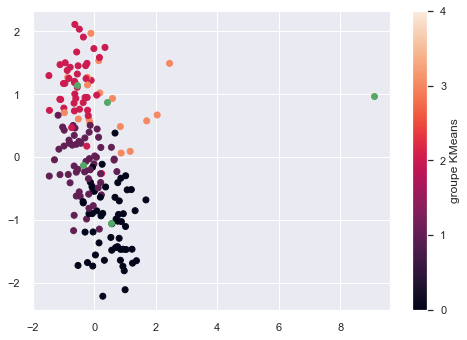

In [54]:
# Visualisation des groupes sur 2 variables
model = KMeans(n_clusters=5)
model.fit(X_scaled)
model.predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c = model.predict(X_scaled))
plt.colorbar(ticks=range(6), label='groupe KMeans')
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='g')

In [55]:
#  Position finale des centroïdes
model.cluster_centers_

array([[ 0.52977282, -1.0561548 , -1.08247049, -1.13029449],
       [-0.36331166, -0.1268144 , -0.09188071,  0.44794386],
       [-0.55442611,  1.15082143,  1.25299013,  1.04077295],
       [ 0.39365657,  0.88120598,  0.5776734 , -0.49351228],
       [ 9.08273195,  0.9779258 ,  1.16593469, -0.1780749 ]])

In [56]:
# Nom des groupes
label = model.labels_
label

array([1, 0, 2, 3, 0, 1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 0,
       2, 1, 0, 0, 0, 1, 3, 1, 0, 1, 3, 1, 3, 0, 2, 1, 1, 2, 1, 3, 1, 2,
       1, 2, 2, 2, 0, 1, 1, 0, 2, 3, 0, 1, 2, 1, 0, 0, 1, 0, 0, 2, 1, 1,
       2, 0, 0, 3, 0, 2, 2, 2, 0, 2, 1, 1, 3, 1, 0, 0, 0, 2, 3, 2, 0, 3,
       0, 0, 2, 1, 0, 0, 1, 2, 3, 2, 3, 1, 1, 1, 3, 0, 1, 0, 0, 2, 1, 1,
       1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1,
       1, 0, 3, 0, 0, 2, 1, 1, 2, 1, 0, 0, 2, 2, 1, 1, 0, 1, 0, 1, 3, 3,
       3, 4, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1])

In [57]:
#  Fonction coût du model inertia : somme des distances entre les points du cluster et le centroïde
model.inertia_

169.0393261090947

In [58]:
df_pays_kmea = df_paysIndex.reset_index()

In [59]:
idk = np.argsort(label)
idk

array([ 86, 135, 133,  81, 126, 125, 124, 121,  48, 116,  51, 114, 113,
        54, 112,  35,  58,  61,  62, 106, 105, 103,  67,  68,  70,  74,
        93,  92,  89,  88,  80,  59, 136, 128, 156,   1, 168,   4, 167,
       165,  11, 160,  13,  14,  17, 150,  21, 148,  82, 143,  30,  24,
        25, 142,  26, 117, 131, 100,  99, 132, 166, 101,  91, 171, 141,
        94, 164, 104, 162, 147, 130, 146, 108, 158, 138, 109, 110, 151,
       149, 120, 119, 163, 139,   0, 173,  55,  50,  49,  44,  42,  40,
        38,  37,   9,  33,  10,  31,  29,  27,  23,  20,  19,  18,  12,
        57,  60,  16,  64,  65,  79,   5,  76,  77, 107,  36,  95, 137,
        73,  75, 140, 161,  90, 145,   8, 170,  22,   2, 172,  85, 159,
        15, 144, 169,  39,  63,  56, 111,  66,   7,  52, 115,   6, 118,
        47,  97, 157, 122, 123,  71,  43,  72, 127,  83, 129,  45,  46,
         3,  84, 154, 153, 152,  28,  32,  34, 134,  53, 102,  69,  98,
        96,  78,  87,  41, 155], dtype=int64)

In [60]:
#index triés des groupes 
idk = np.argsort(label) 
df_pays_kmea_gp = df_pays_kmea.iloc[idk]
df_pays_kmea_gp['pays'] = df_pays_kmea['pays'][idk]
df_pays_kmea_gp['groupeK'] = model.labels_[idk]+1
df_pays_gpe = df_pays_kmea_gp.groupby(['groupeK']).agg({'pays' : 'count'})
df_pays_gpe

,pays
groupeK,
1,55
2,58
3,43
4,17
5,1


In [61]:
df_pays_kmea_gp.reset_index(drop=True, inplace=True)
df_pays_kmea_gp.head()

,pays,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupeK
0,République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
1,Sénégal,32.405846,2453.0,58.32,0.261488,1
2,Sao Tomé-et-Principe,31.292517,2398.0,53.10,0.299435,1
3,Cambodge,17.017164,2473.0,65.66,0.291197,1
4,Zimbabwe,11.654699,2113.0,48.32,0.243377,1


In [62]:
df_gkmean= df_pays_kmea_gp[['pays', 'groupeK']]

#### Identification des groupes de pays formés par KMeans

#### Groupe 1

In [63]:
df_gpe_Km_unK = df_pays_kmea_gp.loc[df_pays_kmea_gp['groupeK'] == 1, ['pays', 'groupeK']].sort_values('pays').set_index('groupeK')
df_gpe_Km_unK.head(2)

,pays
groupeK,
1,Afghanistan
1,Angola


In [64]:
print('Le groupe 1 est composé de {} pays'.format(df_gpe_Km_unK.pays.count()))

Le groupe 1 est composé de 55 pays


#### Groupe 2

In [65]:
df_gpe_Km_deuxK = df_pays_kmea_gp.loc[df_pays_kmea_gp['groupeK'] == 2, ['pays', 'groupeK']].sort_values('pays').set_index('groupeK')
df_gpe_Km_deuxK.head(2)

,pays
groupeK,
2,Afrique du Sud
2,Antigua-et-Barbuda


#### Groupe 3

In [66]:
df_gpe_Km_troisK = df_pays_kmea_gp.loc[df_pays_kmea_gp['groupeK'] == 3, ['pays', 'groupeK']].sort_values('pays').set_index('groupeK')
df_gpe_Km_troisK.head(2)

,pays
groupeK,
3,Albanie
3,Allemagne


#### Groupe 4

In [67]:
df_gpe_Km_quatreK = df_pays_kmea_gp.loc[df_pays_kmea_gp['groupeK'] == 4, ['pays', 'groupeK']].sort_values('pays').set_index('groupeK')
df_gpe_Km_quatreK.head(2)

,pays
groupeK,
4,Algérie
4,Arabie saoudite


####  Groupe 5

In [68]:
df_gpe_Km_cinqK = df_pays_kmea_gp.loc[df_pays_kmea_gp['groupeK'] == 5, ['pays', 'groupeK']].sort_values('pays').set_index('groupeK')
df_gpe_Km_cinqK.head(2)

,pays
groupeK,
5,Émirats arabes unis


In [69]:
df_dispo_gpe_mean_km = df_pays_kmea_gp.groupby(['groupeK']).agg({'diff_pop_pourcent' : 'mean', 'dispo_alim_T_kcal_hab_jr':'mean',
                                        'dispo_proteine_T_g_hab_jr' : 'mean','ratio_prot_ani_dispo_proteine_T':'mean'})
df_dispo_gpe_mean_km

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
groupeK,,,,
1,25.111304,2385.527273,59.750727,0.245635
2,9.208374,2791.913793,79.470517,0.499835
3,5.805247,3350.604651,106.243023,0.595320
4,22.687516,3232.705882,92.799412,0.348199
5,177.411695,3275.000000,104.510000,0.399005


In [70]:
#  vérification du bon choix du nombre de clusters => elbow method
inertia=[]
k_range = range(1, 10)
for k in k_range :
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia_)

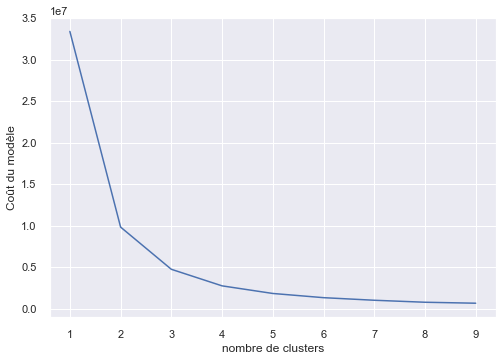

In [71]:
# Visualisation du elbow method
plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('Coût du modèle')
plt.show()

Nous aurions pu travailler avec 3 ou 4 clusters

Utilisation de la librairie "yellowbrick" pour un meilleur graphique


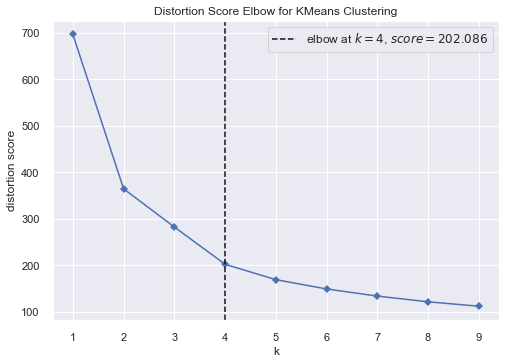

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
# Visualisation du elbow method
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)
visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Conclusion : 4 clusters auraient été suffisant pour l'analyse

#### Comparaison des groupes formés par CAH et Kmeans

In [73]:
# Les groupes CAH et KMeans réunissent globalement les mêmes pays (les noms des groupes sont différents) 
pd.crosstab(label, groupes_cah)

col_0,1,2,3,4,5
row_0,,,,,
0,50,0,0,0,5
1,0,0,3,6,49
2,0,0,39,1,3
3,0,0,0,17,0
4,0,1,0,0,0


In [74]:
df_groupeCah = df_clusters.reset_index()
df_groupeCah.rename(columns={'index': 'groupeCAH', 
                           'pays': 'pays'}, inplace=True)
df_groupeCah.head(2)

,groupeCAH,pays
0,1,République démocratique populaire lao
1,1,Népal


In [75]:
df_pays_Kmean = df_pays_kmea_gp[['pays', 'groupeK']]
df_pays_Kmean.head(2)

,pays,groupeK
0,République démocratique populaire lao,1
1,Sénégal,1


In [76]:
df_compar = pd.merge(df_groupeCah, df_pays_Kmean, on= 'pays').copy()

In [77]:
df_compar.isnull().sum()

groupeCAH    0
pays         0
groupeK      0
dtype: int64

In [78]:
df_compar.head(2)

,groupeCAH,pays,groupeK
0,1,République démocratique populaire lao,1
1,1,Népal,1


In [79]:
df_compar[df_compar["groupeCAH"]==2]

,groupeCAH,pays,groupeK
50,2,Émirats arabes unis,5


<!-- - Le groupe 1 de groupeCAH correspondent au groupe 3 de groupeK -->
<!-- - Le groupe 2 CAH => 5 de groupeK -->
<!-- - Le groupe 3 CAH => 4 de groupeK -->
<!-- - Le groupe 4 CAH => 1 de groupeK -->
<!-- - Le groupe 5 CAH => 3 de groupeK -->

- Le groupe 1 de groupeCAH correspondent au groupe 2 de groupeK
- Le groupe 2 CAH => 5 de groupeK
- Le groupe 3 CAH => 1 de groupeK
- Le groupe 4 CAH => 2 de groupeK
- Le groupe 5 CAH => 4 de groupeK

In [80]:
#  Détermination des pays appartenant à des gpes différents selon la méthode utilisée
df_compar.loc[(df_compar['groupeCAH']== 3 ) & (df_compar['groupeK']!=1) , :]

,groupeCAH,pays,groupeK
51,3,Suède,3
52,3,Roumanie,3
53,3,Italie,3
54,3,Israël,3
55,3,Kazakhstan,3
56,3,Portugal,3
57,3,Slovénie,3
58,3,Tchéquie,3
59,3,Nouvelle-Zélande,3
60,3,Norvège,3


 Les 3 pays devraient appartenir au cluster 4 du kmean

In [81]:
df_compar.loc[(df_compar['groupeCAH']== 4 ) & (df_compar['groupeK']!=2) , :]

,groupeCAH,pays,groupeK
93,4,Azerbaïdjan,4
94,4,Cuba,4
97,4,Arabie saoudite,4
98,4,Algérie,4
99,4,"Chine, continentale",4
100,4,Maroc,4
104,4,Jordanie,4
106,4,Bosnie-Herzégovine,4
107,4,République de Corée,3
108,4,Koweït,4


Les 7 pays n'appartiennent au même cluster sous kmeans

In [82]:
df_compar.loc[(df_compar['groupeCAH']== 5 ) & (df_compar['groupeK']!=4) , :]

,groupeCAH,pays,groupeK
117,5,Ouzbékistan,2
118,5,Ukraine,2
119,5,"Chine, Taiwan Province de",2
120,5,Serbie,2
121,5,Thaïlande,2
122,5,Slovaquie,2
123,5,Saint-Vincent-et-les Grenadines,2
124,5,Uruguay,3
125,5,Samoa,2
126,5,Trinité-et-Tobago,2


Les 8 pays n' appartiennent pas au même cluster avec Kmeans.  

#### Compte tenu des différences entre les deux méthodes de classement et des impératifs du projet, j'opte pour les clusters définis par CAH. Je poursuivrai l'étude avec d'autres variables afin d'affiner le choix des pays.

### Etude par ACP

ACP : préserver une variance max afin d'avoir une projection (sur composantes pricipales) qui reflète le mieux les données

In [83]:
df_dispo_gpe.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
Népal,13.336867,2672.0,68.99,0.165966,1


In [84]:
# Sélection des colonnes à prendre en compte dans l'ACP
df_dispo_gpe_pca = df_dispo_gpe[["diff_pop_pourcent", "dispo_alim_T_kcal_hab_jr", "dispo_proteine_T_g_hab_jr", "ratio_prot_ani_dispo_proteine_T"]]

In [85]:
df_dispo_gpe_pca.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642
Népal,13.336867,2672.0,68.99,0.165966


In [86]:
# Préparation des données pour l'ACP
# Valeurs inconnues remplacées par la moyenne
df_dispo_gpe_pca = df_dispo_gpe_pca.fillna(df_dispo_gpe_pca.mean())
X = df_dispo_gpe_pca.values
names = df_dispo_gpe_pca.index
features = df_dispo_gpe_pca.columns

Données centrées réduites

In [87]:
#  Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [88]:
# Vérification moyenne
np.mean(X_scaled, axis=0)

array([ 8.16715788e-17,  1.63343158e-16, -5.10447368e-16,  1.22507368e-16])

In [89]:
#  Vérification écart type
np.std(X_scaled, axis=0)

array([1., 1., 1., 1.])

#### Choix du nombre de composantes sur lesquelles projeter les données
- Conservation de 80 à 90% de la variance des données afin de conserver la "fidélité" des données

In [90]:
# Calcul des composantes principales (4 variables)
model = PCA(n_components=4)
#  X_reduced : coordonnées factorielles
X_reduced = model.fit_transform(X_scaled)

In [91]:
# Pourcentage de variance préservée pour chacune des composantes
np.cumsum(model.explained_variance_ratio_)

array([0.65547548, 0.87156748, 0.97352886, 1.        ])

In [92]:
# A partir de la 3ème composante on obtient 87% de la variance => réentrainer le model avec 2 composantes
np.argmax((np.cumsum(model.explained_variance_ratio_))>0.87)

1

Variance à 87% à partir de la 2ème composante principale.

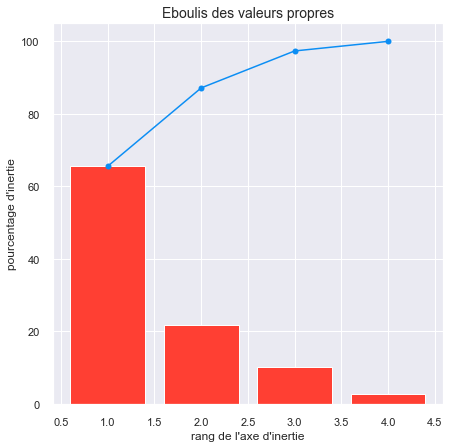

<Figure size 576x396 with 0 Axes>

In [93]:
# Eboulis des valeurs propres
display_scree_plot(model)
plt.savefig("Eboulis des valeurs propres gpeCAH.jpg")

Les 2 premières composantes représentent bien la variance des données.

Ré entrainement du modèle avec le nombre de composantes trouvées précédemment.

In [94]:
n_comp = 2

In [95]:
# Calcul des composantes principales 
model = PCA(n_components = n_comp)
X_reduced = model.fit_transform(X_scaled)

In [96]:
# Vecteurs propres
model.components_

array([[-0.30817855,  0.54974863,  0.57437946,  0.52238938],
       [ 0.9155264 ,  0.28593565,  0.27563195, -0.06386895]])

In [97]:
illustrative_var = df_dispo_gpe.groupe

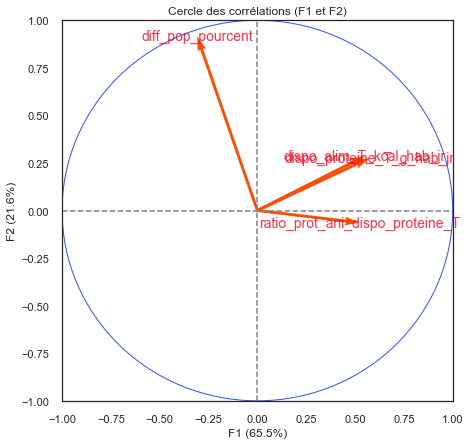

<Figure size 576x396 with 0 Axes>

In [98]:
# Cercle des corrélations
sns.set_style("white")
pcs = model.components_
display_circles(pcs, n_comp, model, [(0,1)], labels = np.array(features))
plt.savefig("Cercle des corrélations gpeCAH.jpg")

In [99]:
df_dispo_gpe.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
Népal,13.336867,2672.0,68.99,0.165966,1


- Données les plus corrélées avec F1 : alimentaire :dispo_alim_T_kcal_hab_jr + dispo_proteine_T_g_hab_jr + ratio_prot_ani_dispo_proteine_T 
- Données les plus corrélées avec F2 : diff_pop_pourcent (corr positive)

 - F1 : axe qui relie les variables liées à l'alimentation (croissante vers la droite)
 - F2 : axe qui relie la croissance de la population (croissante vers le haut) 

#### Interprétation chiffrée

In [100]:
# Composantes principales F1 et F2 (combinaisons linéaires des variables initiales)
pd.DataFrame(X_reduced, index=df_dispo_gpe_pca.index, columns=["F"+str(i+1) for i in range(2)])

,F1,F2
pays,,
République démocratique populaire lao,-1.635219,-0.095603
Népal,-1.383969,-0.301683
Namibie,-1.836603,-0.708866
Mozambique,-2.923278,-0.012176
Ouganda,-2.779477,0.459451
...,...,...
Guyana,0.088538,-0.587160
Grenade,-0.094527,-1.105594
Kiribati,0.161920,0.076185


In [101]:
# Vecteurs propres
model.components_

array([[-0.30817855,  0.54974863,  0.57437946,  0.52238938],
       [ 0.9155264 ,  0.28593565,  0.27563195, -0.06386895]])

In [102]:
f1 = model.components_[0]
f1

array([-0.30817855,  0.54974863,  0.57437946,  0.52238938])

- La composante F1 est une combinaison linéaire des variables telle que :

F1 = -0.30 * *diff_pop_pourcent* + 0.55 * *dispo_alim_T_kcal_hab_jr* + 0.57 * *dispo_proteine_T_g_hab_jr* + 0.52 * *ratio_prot_ani_dispo_proteine_T*

#### On observe que "dispo_alim_T_kcal_hab_jr est la variable qui contribue le plus à F1

- La composante F2 est une combinaison linéaire des variables telle que :

In [103]:
f2 = model.components_[1]
f2

array([ 0.9155264 ,  0.28593565,  0.27563195, -0.06386895])

F2 = 0.92* *diff_pop_pourcent* + 0.29 * *dispo_alim_T_kcal_hab_jr* + 0.28 * *dispo_proteine_T_g_hab_jr* - 0.06 * *ratio_prot_ani_dispo_proteine_T*

#### La variable relative à la croissance de la population  est  fortement corrélée à la composante principale F2.

- La composante F3 est une combinaison linéaire des variables telle que : (non utilisé car travail sur 2 composantes)

In [104]:
# f3 = model.components_[2]
# f3

F3 = -0.25* diff_pop_pourcent + 0.49 * dispo_alim_T_kcal_hab_jr + 0.14 * dispo_proteine_T_g_hab_jr - 0.82 * ratio_prot_ani_dispo_proteine_T

#### La variable relative au ratio_prot_ani_dispo_proteine_T  est  fortement corrélée à la composante principale F3.

In [105]:
# f4 = model.components_[3]
# f4

#### Vérification de la corrélation des variables entre elles

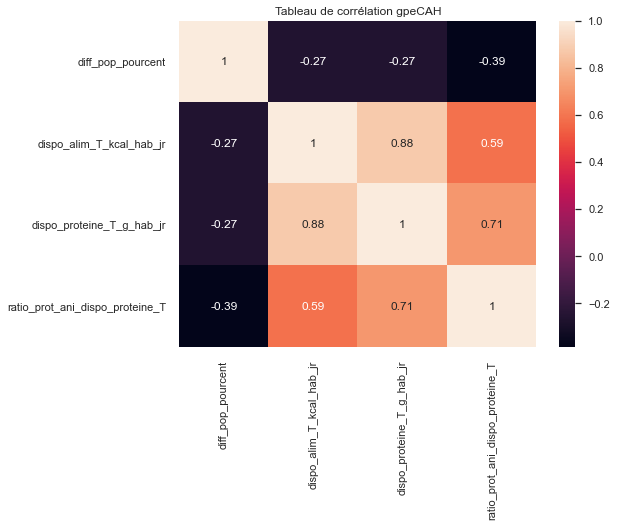

<Figure size 576x396 with 0 Axes>

In [106]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_dispo_gpe_pca.corr(method='pearson'), annot=True)
plt.title('Tableau de corrélation gpeCAH')
plt.show()
plt.savefig("Tableau de corrélation gpeCAH.jpg")

Les variables liées à l'alimentation sont corrélées entre elles. Notamment "dispo_alim_T_kcal_hab_jr" et "dispo_proteine_T_g_hab_jr"

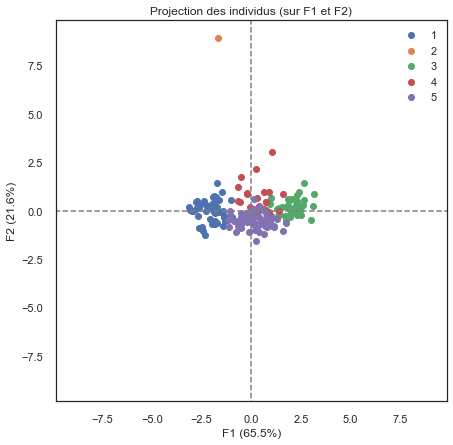

<Figure size 576x396 with 0 Axes>

In [107]:
# Projection des individus
X_projected = model.transform(X_scaled)
display_factorial_planes(X_projected, 2, model, [(0,1)], illustrative_var=illustrative_var)

plt.show()
plt.savefig("Projection des individus gpeCAH.jpg")

#### Visualisation avec les centroïdes

In [108]:
df_dispo_gpe.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
Népal,13.336867,2672.0,68.99,0.165966,1


In [109]:
# 9.08273195,  0.9779258 ,  1.16593469, -0.1780749 => centroide gpe emirat kmeans (gpe5)
# Centroïde : moyenne 
df_centroïde = df_dispo_gpe.groupby('groupe').mean().reset_index()
illustrative_var = df_centroïde.groupe
df_centroïde = df_centroïde.set_index('groupe')
df_centroïde

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
groupe,,,,
1,25.835183,2379.680000,59.306800,0.229238
2,177.411695,3275.000000,104.510000,0.399005
3,7.514480,3333.928571,106.417381,0.600161
4,20.689606,3150.375000,90.214167,0.372324
5,7.835139,2764.017544,77.922982,0.498493


In [110]:
Xc = df_centroïde.values
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [111]:
# X_test_scaled = scaler.transform(Xc)

In [112]:
# X_test_scaled

In [113]:
# X = df_dispo_gpe_pca.values 
Xc = df_centroïde.values
std_scalec = StandardScaler().fit(X)
X_scaledc = std_scalec.transform(Xc)

In [114]:
X_scaledc

array([[ 0.57042476, -1.06952656, -1.10477041, -1.23209553],
       [ 9.08273195,  0.9779258 ,  1.16593469, -0.1780749 ],
       [-0.45843816,  1.11268593,  1.26174869,  1.0708266 ],
       [ 0.28145695,  0.69292853,  0.44780806, -0.34372907],
       [-0.44043042, -0.19060862, -0.16961847,  0.43960758]])

In [115]:
pos_centroïdes = pd.DataFrame(X_scaledc, index=df_centroïde.index, columns=features)
pos_centroïdes.to_csv('P5_04_position_centroides.csv')
pos_centroïdes

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
groupe,,,,
1,0.570425,-1.069527,-1.104770,-1.232096
2,9.082732,0.977926,1.165935,-0.178075
3,-0.458438,1.112686,1.261749,1.070827
4,0.281457,0.692929,0.447808,-0.343729
5,-0.440430,-0.190609,-0.169618,0.439608


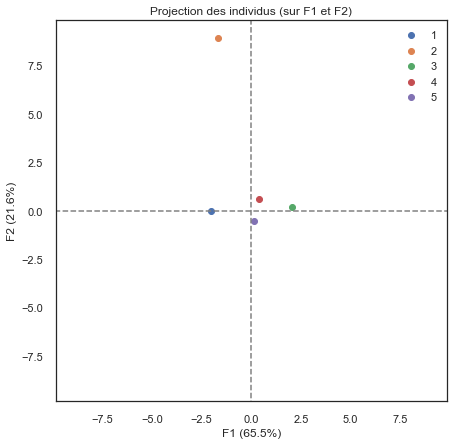

<Figure size 576x396 with 0 Axes>

In [116]:
# Projection des des centroïdes
X_projected_c = model.transform(X_scaledc)
display_factorial_planes(X_projected_c, 2, model, [(0,1)], illustrative_var=df_centroïde.index)

plt.show()
plt.savefig("Projection des centroides gpeCAH.jpg")

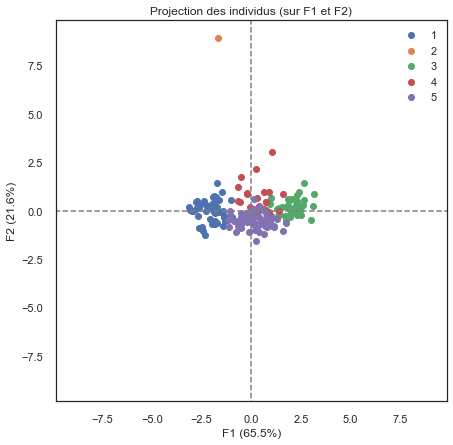

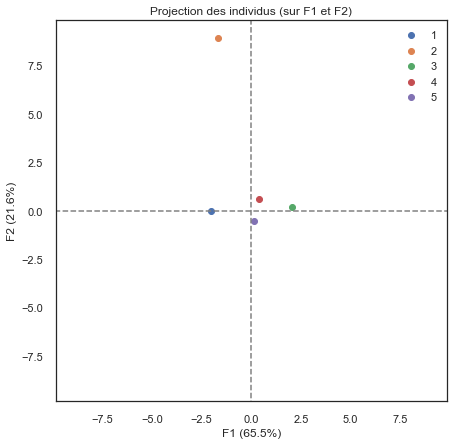

<Figure size 576x396 with 0 Axes>

In [117]:
# Projection des individus et des centroïdes pour une meilleure visibilité
X_projected = model.transform(X_scaled)
display_factorial_planes(X_projected, 2, model, [(0,1)], illustrative_var=df_dispo_gpe.groupe)
X_projected_c = model.transform(X_scaledc)
display_factorial_planes(X_projected_c, 2, model, [(0,1)], illustrative_var=df_centroïde.index)

plt.show()
plt.savefig("Projection des individus et centroides gpeCAH.jpg")

Conclusion : 
- le Gpe 3 est le groupe avec le plus FORT ratio et dispo (kcal et prot)=> riche ?
- le Gpe 1 est le groupe avec le plus FAIBLE ratio et dispo (kcal et prot) => pauvre
- les Gpes 4 et 5 à peu près similaires
- le Gpe 2 est le groupe avec le plus FORT diff_pop mais ratio et dispo FAIBLES

### Tests d'adéquation

Parmi les 4 variables, recherche d'une variable dont la loi est normale 

Représentation graphique des variables continues (une variable suit une loi normale si sa moyenne et la médiane sont égale)

In [118]:
df_paysIndex.head(1)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,
Arménie,-1.943347,2924.0,90.06,0.480124


In [119]:
df_paysIndex.columns

Index(['diff_pop_pourcent', 'dispo_alim_T_kcal_hab_jr',
       'dispo_proteine_T_g_hab_jr', 'ratio_prot_ani_dispo_proteine_T'],
      dtype='object')

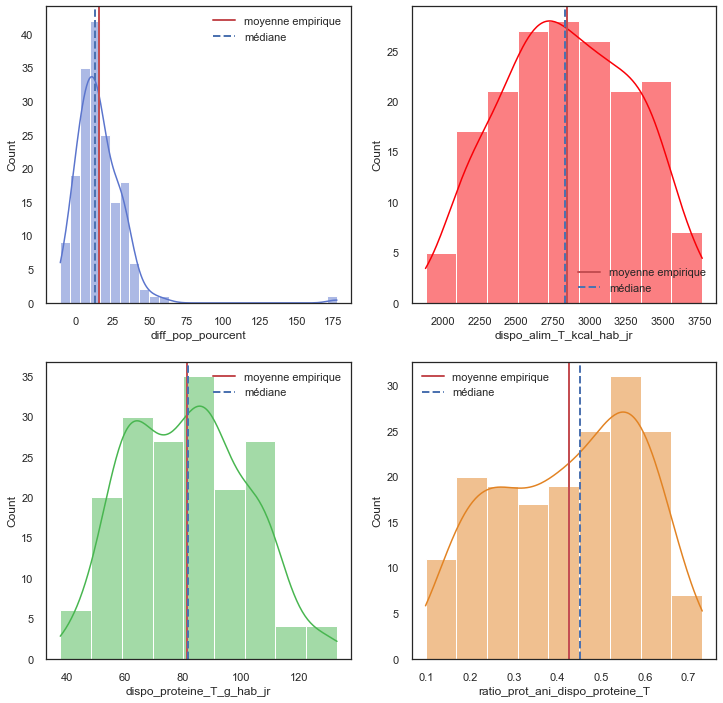

<Figure size 576x396 with 0 Axes>

In [120]:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
sns.histplot(data=df_paysIndex, x="diff_pop_pourcent", kde=True, color="#5b75cd", ax=ax1, )
plt.axvline(np.mean(df_paysIndex["diff_pop_pourcent"]), color='r', linewidth=2, label='moyenne empirique')
plt.axvline(np.median(df_paysIndex["diff_pop_pourcent"]), color='b', linewidth=2,
            linestyle='dashed', label='médiane')
plt.legend()

ax2 = plt.subplot(2, 2, 2)
sns.histplot(data=df_paysIndex, x="dispo_alim_T_kcal_hab_jr", kde=True, color="#f90007", ax=ax2 )
plt.axvline(np.mean(df_paysIndex["dispo_alim_T_kcal_hab_jr"]), color='r', linewidth=2, label='moyenne empirique')
plt.axvline(np.median(df_paysIndex["dispo_alim_T_kcal_hab_jr"]), color='b', linewidth=2, linestyle='dashed', label='médiane')
plt.legend()

ax3 = plt.subplot(2, 2, 3)
sns.histplot(data=df_paysIndex, x="dispo_proteine_T_g_hab_jr", kde=True, color="#48B650", ax=ax3)
plt.axvline(np.mean(df_paysIndex["dispo_proteine_T_g_hab_jr"]), color='r', linewidth=2, label='moyenne empirique')
plt.axvline(np.median(df_paysIndex["dispo_proteine_T_g_hab_jr"]), color='b', linewidth=2, linestyle='dashed', label='médiane')
plt.legend()

ax4 = plt.subplot(2, 2, 4)
sns.histplot(data=df_paysIndex, x="ratio_prot_ani_dispo_proteine_T", kde=True, color="#e28323", ax=ax4)
plt.axvline(np.mean(df_paysIndex["ratio_prot_ani_dispo_proteine_T"]), color='r', linewidth=2, label='moyenne empirique')
plt.axvline(np.median(df_paysIndex["ratio_prot_ani_dispo_proteine_T"]), color='b', linewidth=2, linestyle='dashed', label='médiane')
plt.legend()

plt.legend()
plt.show()
plt.savefig("variables.jpg")

skewness diff_pop_pourcent:
 4.472829084875647
kurtosis diff_pop_pourcent:
 38.059356347944146


<Figure size 576x396 with 0 Axes>

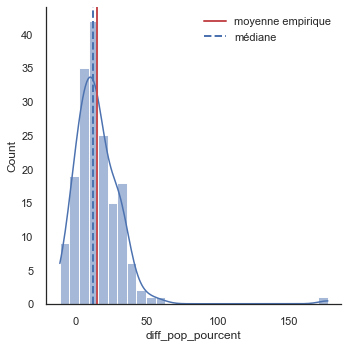

skewness dispo_alim_T_kcal_hab_jr:
 -0.009371141046184047
kurtosis dispo_alim_T_kcal_hab_jr:
 -0.8412837731229192


<Figure size 576x396 with 0 Axes>

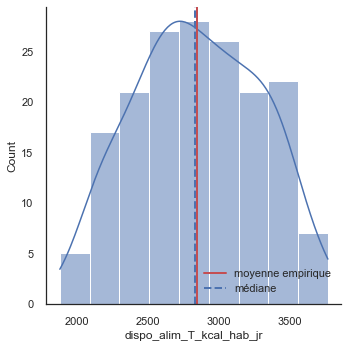

skewness dispo_proteine_T_g_hab_jr:
 0.2188672631538884
kurtosis dispo_proteine_T_g_hab_jr:
 -0.6309517047820346


<Figure size 576x396 with 0 Axes>

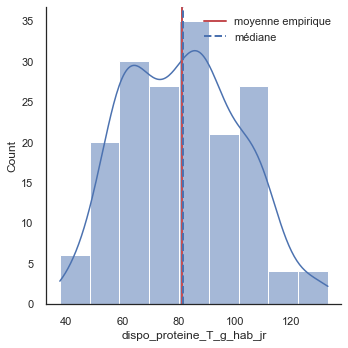

skewness ratio_prot_ani_dispo_proteine_T:
 -0.2117860402101304
kurtosis ratio_prot_ani_dispo_proteine_T:
 -1.1042121348206644


<Figure size 576x396 with 0 Axes>

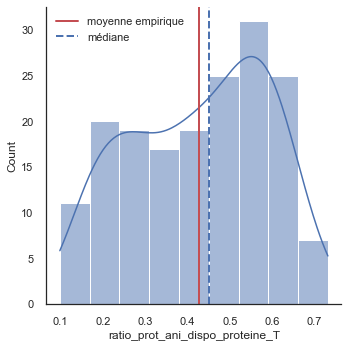

In [121]:
colonne = df_paysIndex.columns
for col in colonne:
    plt.figure()
    sns.displot(df_paysIndex[col], kde=True)     
    plt.axvline(np.mean(df_paysIndex[col]), color='r', linewidth=2, label='moyenne empirique')
    plt.axvline(np.median(df_paysIndex[col]), color='b', linewidth=2, linestyle='dashed', label='médiane')
    
    plt.legend()
    print(f'skewness {col}:\n',df_paysIndex[col].skew())
    print(f"kurtosis {col}:\n",df_paysIndex[col].kurtosis())
    plt.show()

In [122]:
label

array([1, 0, 2, 3, 0, 1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 0,
       2, 1, 0, 0, 0, 1, 3, 1, 0, 1, 3, 1, 3, 0, 2, 1, 1, 2, 1, 3, 1, 2,
       1, 2, 2, 2, 0, 1, 1, 0, 2, 3, 0, 1, 2, 1, 0, 0, 1, 0, 0, 2, 1, 1,
       2, 0, 0, 3, 0, 2, 2, 2, 0, 2, 1, 1, 3, 1, 0, 0, 0, 2, 3, 2, 0, 3,
       0, 0, 2, 1, 0, 0, 1, 2, 3, 2, 3, 1, 1, 1, 3, 0, 1, 0, 0, 2, 1, 1,
       1, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1,
       1, 0, 3, 0, 0, 2, 1, 1, 2, 1, 0, 0, 2, 2, 1, 1, 0, 1, 0, 1, 3, 3,
       3, 4, 0, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1])

Il semble graphiquement que les variables 'dispo_proteine_T_g_hab_jr' et 'dispo_alim_T_kcal_hab_jr' suivent une loi normale. Nous devons effectuer des tests pour le confirmer.

### Tests de normalité

 Variable 'diff_pop_pourcent'

####  Test de Kolmogorov-Smirnov sur les différentes variables (en colonnes) afin de tester l’adéquation de ces dernières à une loi normale.
Hypothèses :
- H0 : la variable suit une loi normale
- H1 : la variable ne suit pas une loi normale
- Seuil 5%

In [123]:
df_paysIndex.columns

Index(['diff_pop_pourcent', 'dispo_alim_T_kcal_hab_jr',
       'dispo_proteine_T_g_hab_jr', 'ratio_prot_ani_dispo_proteine_T'],
      dtype='object')

In [124]:
ks_2samp(df_paysIndex["diff_pop_pourcent"],list(np.random.normal(np.mean(df_paysIndex["diff_pop_pourcent"]), np.std(df_paysIndex["diff_pop_pourcent"]), 1000)))

KstestResult(statistic=0.11888505747126436, pvalue=0.027571571875133594)

P_value = 0.0024: On peut donc rejetter l’hypothèse de normalité au niveau de test 5%. 

Variable 'dispo_alim_T_kcal_hab_jr'

In [125]:
ks_2samp(df_paysIndex["dispo_alim_T_kcal_hab_jr"],list(np.random.normal(np.mean(df_paysIndex["dispo_alim_T_kcal_hab_jr"]), np.std(df_paysIndex["dispo_alim_T_kcal_hab_jr"]), 1000)))

KstestResult(statistic=0.06163218390804598, pvalue=0.6013455782082129)

In [126]:
ks_2samp(df_paysIndex["dispo_proteine_T_g_hab_jr"],list(np.random.normal(np.mean(df_paysIndex["dispo_proteine_T_g_hab_jr"]), np.std(df_paysIndex["dispo_proteine_T_g_hab_jr"]), 1000)))

KstestResult(statistic=0.07259770114942529, pvalue=0.39422062499535115)

In [127]:
ks_2samp(df_paysIndex["ratio_prot_ani_dispo_proteine_T"],list(np.random.normal(np.mean(df_paysIndex["ratio_prot_ani_dispo_proteine_T"]), np.std(df_paysIndex["ratio_prot_ani_dispo_proteine_T"]), 1000)))

KstestResult(statistic=0.07963218390804598, pvalue=0.28667390910817825)

On ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5%. 

In [128]:
def ks_2samp_test(col, df):
    alpha = 0.05
    stat, p_value = ks_2samp(df[col],list(np.random.normal(np.mean(df[col]), np.std(df[col]), 1000)))
    print(f'p_value :{p_value}')
    
    if p_value < alpha :
        return(f'HO rejetée, la variable {col} ne suit pas une loi normale')
    else :
        return (f'HO ne peut pas être rejetée, la variable {col} suit une loi NORMALE')

In [129]:
colonne = df_paysIndex.columns
for col in colonne :
    print(f'{col :-<32}{ks_2samp_test(col, df_paysIndex)}\n') 

p_value :0.07950713864743142
diff_pop_pourcent---------------HO ne peut pas être rejetée, la variable diff_pop_pourcent suit une loi NORMALE

p_value :0.31488463518362797
dispo_alim_T_kcal_hab_jr--------HO ne peut pas être rejetée, la variable dispo_alim_T_kcal_hab_jr suit une loi NORMALE

p_value :0.1638217192622462
dispo_proteine_T_g_hab_jr-------HO ne peut pas être rejetée, la variable dispo_proteine_T_g_hab_jr suit une loi NORMALE

p_value :0.0938072505414772
ratio_prot_ani_dispo_proteine_T-HO ne peut pas être rejetée, la variable ratio_prot_ani_dispo_proteine_T suit une loi NORMALE



Seules les variables **"dispo_alim_T_kcal_hab_jr"** et **"dispo_proteine_T_g_hab_jr"** suivent une loi gaussienne pour un seuil de 5%.

Agostino et Pearson’s test (combine skew et kurtosis) https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

- H0 : normalité
- H1 : non normalité

In [130]:
k2, p = st.normaltest(df_paysIndex['dispo_proteine_T_g_hab_jr'])
p

0.028801674950858735

In [131]:
def normalTest(col,df) : 
    alpha = 0.01
    k2, p_value = st.normaltest(df[col])
    print(p_value)    
    if p_value <= alpha :
        return(f'HO rejetée, la variable {col} ne suit pas une loi normale')
    else :
        return (f'HO ne peut pas être rejetée, la variable {col} suit une loi NORMALE')
    

In [132]:
colonne = df_paysIndex.columns
for col in colonne :
    print(f'{col :-<32}{normalTest(col, df_paysIndex)}\n') 

4.37254064258106e-45
diff_pop_pourcent---------------HO rejetée, la variable diff_pop_pourcent ne suit pas une loi normale

0.0006323694442796712
dispo_alim_T_kcal_hab_jr--------HO rejetée, la variable dispo_alim_T_kcal_hab_jr ne suit pas une loi normale

0.028801674950858735
dispo_proteine_T_g_hab_jr-------HO ne peut pas être rejetée, la variable dispo_proteine_T_g_hab_jr suit une loi NORMALE

3.0253121743849233e-11
ratio_prot_ani_dispo_proteine_T-HO rejetée, la variable ratio_prot_ani_dispo_proteine_T ne suit pas une loi normale



#### QQ plot

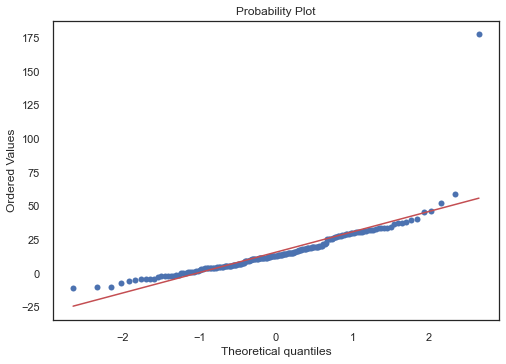

In [133]:
import pylab
import scipy.stats as stats
measurements = df_paysIndex['diff_pop_pourcent']
stats.probplot(measurements, dist='norm', plot=pylab)
pylab.show()

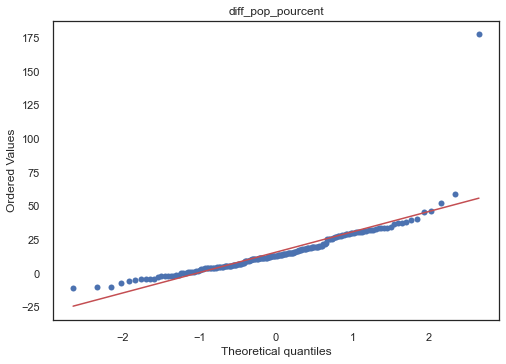

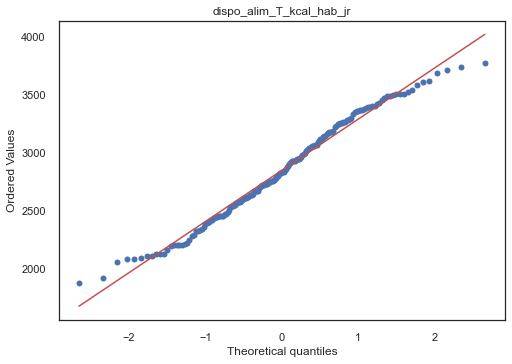

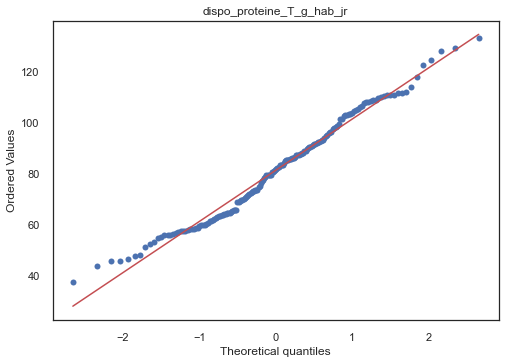

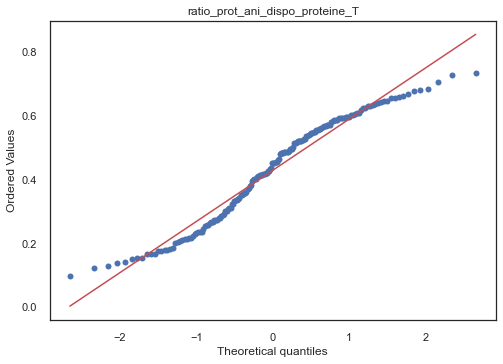

In [134]:
colonne = df_paysIndex.columns
for col in colonne :
    measurements = df_paysIndex[col]
    stats.probplot(measurements, dist='norm', plot=pylab)
    pylab.title(f'{col}')
    pylab.show()

####  La variable "dispo_proteine_T_g_hab_jr" suit une loi normale. 

### Les groupes sont-ils vraiment distincts ? (tests d'égalité des variances et des moyennes)

In [135]:
df_dispo_gpe.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
Népal,13.336867,2672.0,68.99,0.165966,1


####  Visualisation des groupes par boxplot

- Variable : **"dispo_proteine_T_g_hab_jr"**-- variable suivant la loi gaussienne sur tous les tests

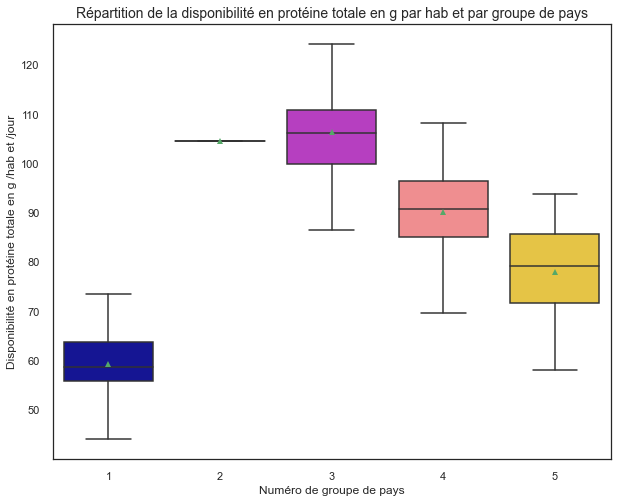

<Figure size 576x396 with 0 Axes>

In [136]:
plt.figure(figsize=(10,8))
sns.boxplot(x='groupe', y='dispo_proteine_T_g_hab_jr', data=df_dispo_gpe, palette= 'gnuplot2', showmeans=True,showfliers=False)
plt.title('Répartition de la disponibilité en protéine totale en g par hab et par groupe de pays', size=14)
plt.ylabel('Disponibilité en protéine totale en g /hab et /jour', size= 12)
plt.xlabel('Numéro de groupe de pays', size=12)
plt.show()
plt.savefig("boxplot.jpg")

#### Test sur la variance 

Les groupes 3, 4 (et 5) sont assez similaires. Nous allons les tester avec un levene's test (test d'homogénéïté des variances). Le levene test est plus "souple" concernant la normalité des distributions (par rapport à un Bartlett’s Test)

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [137]:
gpe1 = df_dispo_gpe[df_dispo_gpe['groupe']==1]['dispo_proteine_T_g_hab_jr']

In [138]:
gpe3 = df_dispo_gpe[df_dispo_gpe['groupe']==3]['dispo_proteine_T_g_hab_jr']

In [139]:
gpe4 = df_dispo_gpe[df_dispo_gpe['groupe']==4]['dispo_proteine_T_g_hab_jr']

In [140]:
gpe5 = df_dispo_gpe[df_dispo_gpe['groupe']==5]['dispo_proteine_T_g_hab_jr']

#### Les groupes 3 et 4 se ressemblent. Vérifions qu'ils sont distincts. ( 'dispo_proteine_T_g_hab_jr' variable gaussienne)

- Test d'égalité des variances 

In [141]:
# Test de levene sur les gpes 3, 4 
stat, p_value = levene(gpe3, gpe4)
p_value

0.6126844324543048

#### La p_value est égale à 0.61 donc supérieure significativement au seuil alpha. H0 ne peut pas être rejetée. Les variances des groupes 3 et 4 sont sigificativement égales.

In [142]:
# Test de levene sur les gpes 3, 4 et 5, 1
stat, p_value = levene(gpe3, gpe4, gpe5, gpe1)
p_value

0.3976694242808072

La p_value est égale à 0.85 donc supérieure au seuil alpha. HO  ne peut pas être rejetée. Les variances sont égales.

In [143]:
# import pingouin as pg

# # Levene's Test in Python using Pingouin
# pg.homoscedasticity(df_dispo_gpe, dv='df_dispo_gpe', 
#                     group='groupe')

#### Test de bartlett

In [144]:
from scipy.stats import bartlett
stat, p = bartlett(gpe3, gpe4, gpe5, gpe1)
p

0.47652715816869473

HO ne peut pas être rejettée au seuil alpha. **Les variances de nos groupes sont similaires**.

#### Test d'Anova

Test sur les groupes 1, 3, 4 et 5

Hypothèses :
- H0 : les moyennes des groupes sont égales
- H1 : les moyennes des groupes sont différentes
- seuil alpha : 0.05

On ramène les groupes à la même taille

In [145]:
gpe1.shape

(50,)

In [146]:
gpe3.shape

(42,)

In [147]:
gpe4.shape

(24,)

In [148]:
gpe5.shape

(57,)

In [149]:
# Echantillon avec nb d'observation du groupe 1identique au groupe 4
df_gpeProtUnsampleAleatoire = gpe5.sample(gpe4.shape[0])

In [150]:
# Echantillon avec nb d'observation du groupe 3 identique au groupe 4
df_gpeProtTroissampleAleatoire = gpe5.sample(gpe4.shape[0])

In [151]:
# Echantillon avec nb d'observation du groupe 5 identique au groupe 4
df_gpeProtCinqsampleAleatoire = gpe5.sample(gpe4.shape[0])

In [152]:
fvalue, pvalue = stats.f_oneway(df_gpeProtUnsampleAleatoire, df_gpeProtTroissampleAleatoire, gpe4, df_gpeProtCinqsampleAleatoire)
pvalue

2.03469728441268e-05

La pvalue est significative (pvalue << alpha). HO est rejeté. **Les groupes sont différents**.

#### Test d'égalité des moyennes sur groupes 3 et 4

Hypothèses :
- H0 : les moyennes des groupes sont égales
- H1 : les moyennes des groupes sont différentes
- seuil alpha : 0.05

In [153]:
fvalue, pvalue = stats.f_oneway(df_gpeProtTroissampleAleatoire, gpe4)
pvalue

0.00011902816830825783

La pvalue est significative (pvalue << alpha). HO est rejeté. Les moyennes des gpes 3 et 4 sont significativement différentes. **Les groupes sont différents**.

#### Juste pour voir....

Avec un test de student sur les groupes 3 et 4

Hypothèses :
- H0 : m4 = m5
- H1 : m4 != m5
- seuil alpha = 0.05

In [154]:
from scipy.stats import ttest_ind
st.ttest_ind(gpe4.dropna(), df_gpeProtTroissampleAleatoire.dropna())

Ttest_indResult(statistic=4.205557651440395, pvalue=0.00011902816830825878)

La p_value (2.54.10-5) est significativement inférieure au seuil alpha de 0.05 donc nous rejetons l'hypothèse HO. Les moyennes des clusters 3 et 4 sont significativement différentes. Les clusters sont donc significativement distincts.

#### Test sur la moyenne (Ttest)

Les groupes 4 et 5 sont assez similaires. Nous allons les tester avec un Student Test

Hypothèses :
- H0 : m4 = m5
- H1 : m4 != m5
- seuil alpha = 0.05

In [155]:
from scipy.stats import ttest_ind
st.ttest_ind(gpe4.dropna(), df_gpeProtCinqsampleAleatoire.dropna(),equal_var=True)

Ttest_indResult(statistic=4.665608505751664, pvalue=2.6745475166388152e-05)

La p_value est inférieure au seuil alpha de 0.05 donc nous rejetons l'hypothèse HO. Les moyennes des 2 clusters (4 et 5) sont significativement différentes. **Les clusters sont donc significativement distincts**.

### Groupe 2 (Emirats arabes) outsider (valeur extrême)

#### Le groupe 2 est très éloigné des autres. Il "écrase" de ce fait les autres groupes. Afin de recueillir de meilleures informations sur ces  groupes et compte tenu que le groupe 2 est à présent bien identifié, j'écarte les Emirats arabes et refais une analyse.

Retrait du groupe 2 du dataframe

In [156]:
# Retrait du groupe 2 du dataframe
df_sans_deux = df_dispo_gpe.drop(df_dispo_gpe.loc[df_dispo_gpe['groupe']==2].index)
df_sans_deux.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
Népal,13.336867,2672.0,68.99,0.165966,1


In [157]:
df_sans_deux.shape

(173, 5)

In [158]:
# Vérification de la suppression des EA du dataframe
df_sans_deux.loc[(df_dispo_gpe['groupe']==2) ,:]

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,groupe
pays,,,,,


### Recherche des nouveaux groupes (sans EA) avec KMeans

Centrage et réduction des données

In [159]:
# Suppression de la colonne "groupe" de "df_sans_deux"
df_sans_deux = df_sans_deux.drop('groupe', axis=1)
df_sans_deux.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642
Népal,13.336867,2672.0,68.99,0.165966


In [160]:
# préparation des données pour le clustering
Xsd = df_sans_deux.values
names = df_sans_deux.index

In [161]:
#  Standardisation des données
scaler = StandardScaler()
X_scaledSd = scaler.fit_transform(Xsd)

In [162]:
# Vérification de la standardisation (moyenne = 0)
X_scaledSd.mean(axis=0)

array([ 2.05359172e-17, -4.10718344e-17,  4.31254262e-16,  5.13397930e-16])

In [163]:
# Vérification de la standardisation (écart type = 1)
X_scaledSd.std(axis=0)

array([1., 1., 1., 1.])

In [164]:
# Nombre de clusters
nb_cluster = 3

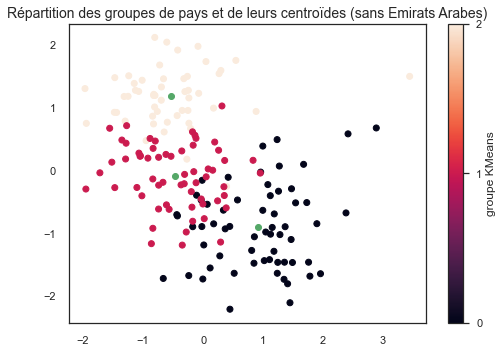

<Figure size 576x396 with 0 Axes>

In [165]:
# Représentation des individus et des clusters (en vert) sur les 2 premières variables
km = KMeans(n_clusters=nb_cluster)
km.fit(X_scaledSd)
km.predict(X_scaledSd)
plt.scatter(X_scaledSd[:,0], X_scaledSd[:,1], c = km.predict(X_scaledSd))
plt.colorbar(ticks=range(6), label='groupe KMeans')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='g')
plt.title('Répartition des groupes de pays et de leurs centroïdes (sans Emirats Arabes)', size=14)
plt.show()
plt.savefig("Répartition des groupes de pays et de leurs centroïdes (sans Emirats Arabes).jpg")

In [166]:
# Coordonnées des centroïdes
km.cluster_centers_

array([[ 0.91832247, -0.90041483, -0.96394752, -1.04304301],
       [-0.46738715, -0.08286639, -0.04621548,  0.372046  ],
       [-0.53935401,  1.17608146,  1.20823418,  0.80256505]])

#### Analyse chiffrée "manuelle" du clustering ( moyenne, écart type...)

In [167]:
# # Création des clusters par KMeans
# from sklearn import cluster
# res = cluster.KMeans(n_clusters=nb_cluster)
# res.fit(X_scaledSd)

In [168]:
# N° de groupe des pays
# res.labels_

In [169]:
#  Effectif par groupe
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2]), array([61, 61, 51], dtype=int64))

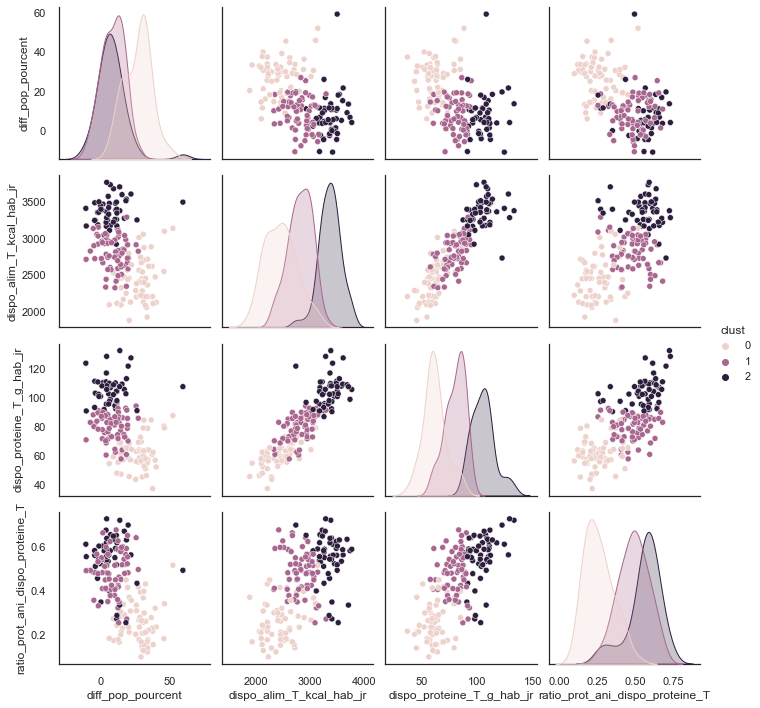

In [170]:
# Ajout des groupes au dataframe (création d'une colonne 'clust')
df_sans_deux_clt = df_sans_deux.copy()
df_sans_deux_clt['clust'] = km.labels_
# pairplot pour voir l'influence des variables dans les groupes
sns.pairplot(df_sans_deux_clt, hue='clust')

Fonctions de densité : il n'y a pas vraiment de diff entre cluster 0 et 2. Diff plus nette entre clusters 0 et 1 sur la variable ratio, et dispo_prot et dispo_alim. Pas beaucoup de diff avec la variable diff_pop_pourcent entre les clusters.

In [171]:
# Regroupement par "groupe"
gb = df_sans_deux.groupby(km.labels_)

In [172]:
# Effectif par groupe
gb.size()

0    61
1    61
2    51
dtype: int64

Remarque : les groupes sont équilibrés

In [173]:
# Moyenne par groupe
gb.mean()

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
0,26.604465,2451.114754,61.996393,0.259384
1,8.705859,2808.655738,80.246393,0.487944
2,7.776295,3359.235294,105.192353,0.557480


Remarques :
- Gpe 1 : FORTE **diff_pop_pourcent**, FAIBLES **dispo_alim_T_kcal_hab_jr**,  **dispo_proteine_T_g_hab_jr**, **ratio_prot_ani_dispo_proteine_T** : les pays concernés sont plutôt pauvres
- Gpe 0 : FAIBLE **diff_pop_pourcent**, FORTS **dispo_alim_T_kcal_hab_jr**,  **dispo_proteine_T_g_hab_jr**, **ratio_prot_ani_dispo_proteine_T** : les pays concernés sont plutôt riches
- Gpe 2 : MOYEN en **tout**

In [174]:
# Coordonnées des centroïdes
clusters = km.labels_
clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0,
       2, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1])

In [175]:
# Position des centroïdes
km.cluster_centers_

array([[ 0.91832247, -0.90041483, -0.96394752, -1.04304301],
       [-0.46738715, -0.08286639, -0.04621548,  0.372046  ],
       [-0.53935401,  1.17608146,  1.20823418,  0.80256505]])

Calcul du nombre de clusters optimal (méthode du coude)

In [176]:
#  inertia : somme des distances des données avec le centroïde
inertia = [] 
K_range = range(1,20)
for k in K_range :
    kmv = KMeans(n_clusters=k).fit(X_scaledSd)
    inertia.append(kmv.inertia_)

Text(0.5, 1.0, 'Elbow method')

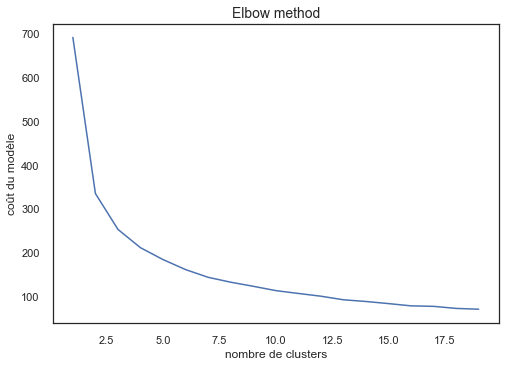

In [177]:
plt.plot(K_range, inertia)
plt.xlabel('nombre de clusters', size=12)
plt.ylabel('coût du modèle', size=12)
plt.title('Elbow method', size=14)

Le nombre de clusters optimal est de 3 - 4

Autre visualisation de la méthode du coude

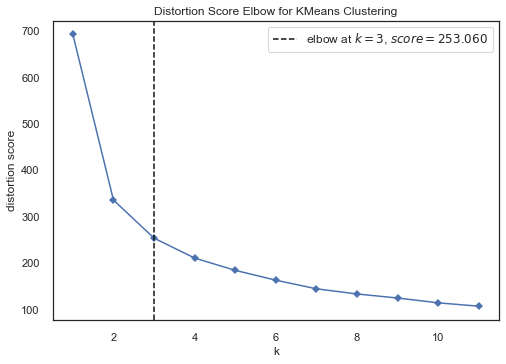

<Figure size 576x396 with 0 Axes>

In [178]:
# Décroissance de l'inertie interclasse (k:clusters)
visualizer = KElbowVisualizer(km, k=(1,12), timings=False)
visualizer.fit(X_scaledSd)        # Fit the data to the visualizer
visualizer.show()
plt.savefig("Elbow gpeK.jpg")


Le nombre optimal de clusters est de 3. Le nombre de groupes est donc bon.

In [179]:
# confirmation du nombre de groupe à 3
nb_cluster = 3

In [180]:
# Re clustering à 3
kmb = KMeans(n_clusters=nb_cluster)
kmb.fit(X_scaledSd)
kmb.predict(X_scaledSd)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 1,
       0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2])

In [181]:
# Clusters
cluster = kmb.labels_

In [182]:
df_sans_deux_gpe = pd.DataFrame({'clusters': cluster, 'pays': names })
df_sans_deux_gpe = df_sans_deux_gpe.sort_values('clusters')
df_sans_deux_gpe.head(2)

,clusters,pays
86,0,Australie
81,0,États-Unis d'Amérique


In [183]:
df_sans_deux_gpe_gpeK =  df_sans_deux_gpe.groupby('clusters')

In [184]:
df_sans_deux_gpe_gpeK.head(2)

,clusters,pays
86,0,Australie
81,0,États-Unis d'Amérique
111,1,Oman
114,1,Mauritanie
146,2,Barbade
142,2,Bulgarie


In [185]:
df_sans_deux_gpe_gpeK.size()

clusters
0    51
1    61
2    61
dtype: int64

Les clusters sont équilibrés (50-60 pays par clusters)

In [186]:
df_sans_deux

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642
Népal,13.336867,2672.0,68.99,0.165966
Namibie,16.254417,2166.0,57.61,0.339351
Mozambique,29.995471,2282.0,45.68,0.138792
Ouganda,40.021611,2126.0,52.64,0.235182
...,...,...,...,...
Guyana,6.100796,2762.0,79.27,0.455027
Grenade,3.921569,2442.0,69.20,0.600578
Kiribati,17.241379,3042.0,73.34,0.481320


In [187]:
# Regroupement par "groupe"
gbbis = df_sans_deux.groupby(kmb.labels_)

In [188]:
# Caractéristiques des différents groupes
gbbis.mean()

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
0,7.776295,3359.235294,105.192353,0.557480
1,26.604465,2451.114754,61.996393,0.259384
2,8.705859,2808.655738,80.246393,0.487944


In [189]:
# Pour avoir le descriptif du groupe 2
df_gpeff = df_sans_deux_gpe[df_sans_deux_gpe['clusters']==2]
df_gpeff.sort_values(by='pays').pays.values

array(['Afrique du Sud', 'Algérie', 'Antigua-et-Barbuda', 'Arménie',
       'Azerbaïdjan', 'Bahamas', 'Barbade', 'Bermudes',
       'Bosnie-Herzégovine', 'Botswana', 'Brunéi Darussalam', 'Bulgarie',
       'Cabo Verde', 'Chili', 'Chine - RAS de Macao',
       'Chine, Taiwan Province de', 'Chypre', 'Colombie', 'Costa Rica',
       'Croatie', 'Dominique', 'El Salvador', 'Fidji', 'Gabon', 'Grenade',
       'Guyana', 'Géorgie', 'Hongrie', "Iran (République islamique d')",
       'Jamaïque', 'Japon', 'Kirghizistan', 'Kiribati',
       'Macédoine du Nord', 'Malaisie', 'Maurice', 'Mexique', 'Mongolie',
       'Myanmar', 'Nouvelle-Calédonie', 'Ouzbékistan', 'Panama',
       'Paraguay', 'Pérou', 'République de Moldova',
       'République dominicaine', 'Saint-Kitts-et-Nevis',
       'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa',
       'Serbie', 'Slovaquie', 'Soudan', 'Suriname', 'Thaïlande',
       'Trinité-et-Tobago', 'Turkménistan', 'Ukraine',
       'Venezuela (République boliv

In [190]:
# Groupe 0
df_gpe0 = df_sans_deux_gpe[df_sans_deux_gpe['clusters']==0]
df_gpe0.head(2)

,clusters,pays
86,0,Australie
81,0,États-Unis d'Amérique


In [191]:
# Groupe 1
df_gpe1 = df_sans_deux_gpe[df_sans_deux_gpe['clusters']==1]
df_gpe1.head(2)

,clusters,pays
111,1,Oman
114,1,Mauritanie


In [192]:
df_gpe2 = df_sans_deux_gpe[df_sans_deux_gpe['clusters']==2]
df_gpe2.head(2)

,clusters,pays
146,2,Barbade
142,2,Bulgarie


Construction du dendrogramme

In [193]:
# # Calcul de la distance entre chaque échantillon 
# Z = linkage(X_scaledSd,method='ward',metric='euclidean')

In [194]:
# #affichage du dendrogramme
# sns.set_style("white")
# plt.figure(figsize=(10,25))
# plt.title("Hierarchical Clustering Dendrogram")

# dendrogram(Z,labels=names,orientation='left',
#       color_threshold=9)
# plt.axvline(x=9, c='b',linestyle='dashed', lw=0.5, label='découpe pour avoir les 4 groupes')
# plt.xlabel('distance')
# plt.legend(loc='upper left')
# # plt.savefig("CAH.jpg")
# plt.show()

In [195]:
# clustersSD = fcluster(Z, 4, criterion='maxclust')
# clustersSD

#### ACP sur les groupes

In [196]:
# Récupération des variables pour l'ACP 
df_sans_deux_acp = df_sans_deux[["diff_pop_pourcent", "dispo_alim_T_kcal_hab_jr", "dispo_proteine_T_g_hab_jr", "ratio_prot_ani_dispo_proteine_T"]]

In [197]:
# préparation des données pour l'ACP
df_sans_deux_acp = df_sans_deux_acp.fillna(df_dispo_gpe_pca.mean())
Xsd_pca = df_sans_deux_acp.values
names = df_sans_deux_acp.index
features = df_sans_deux_acp.columns

In [198]:
df_sans_deux_acp.head(2)

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,
République démocratique populaire lao,20.484072,2455.0,68.89,0.211642
Népal,13.336867,2672.0,68.99,0.165966


In [199]:
# Attribution des groupes (sans EA) au dataframe
df_sans_deux_acp_gpe = pd.merge(df_sans_deux_acp,df_sans_deux_gpe, on='pays')
df_sans_deux_acp_gpe.head(2)

,pays,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,clusters
0,République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
1,Népal,13.336867,2672.0,68.99,0.165966,1


In [200]:
# Centrage et réduction des données
std_scale = StandardScaler().fit(Xsd_pca)
X_scaled_SD = std_scale.transform(Xsd_pca)

In [201]:
# Nombre de composantes
n_comp = 4

In [202]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
# pca.fit(X_scaled_SD)
X_reduced = pca.fit_transform(X_scaled_SD)

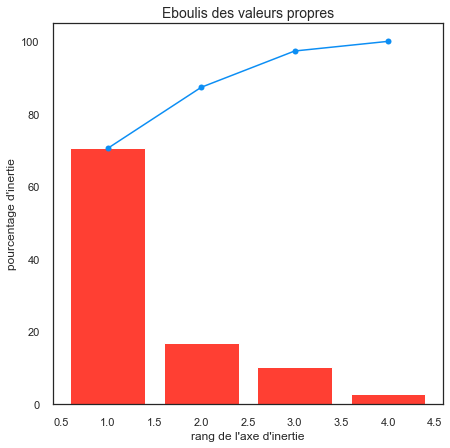

<Figure size 576x396 with 0 Axes>

In [203]:
# Eboulis des valeurs propres
display_scree_plot(pca)
plt.savefig("Eboulis des valeurs propres gpeK.jpg")

On peut travailler sur 2 composantes seulement.

Ré entrainement du modèle avec le nombre de composantes trouvées précédement.

In [204]:
# Nombre de composantes
n_comp = 2

In [205]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
# pca.fit(X_scaled_SD)
X_reduced = pca.fit_transform(X_scaled_SD)

In [206]:
# Vecteurs propres
pca.components_

array([[ 0.40818605, -0.52650979, -0.55090211, -0.50267132],
       [ 0.84943642,  0.38785421,  0.34506315, -0.09464826]])

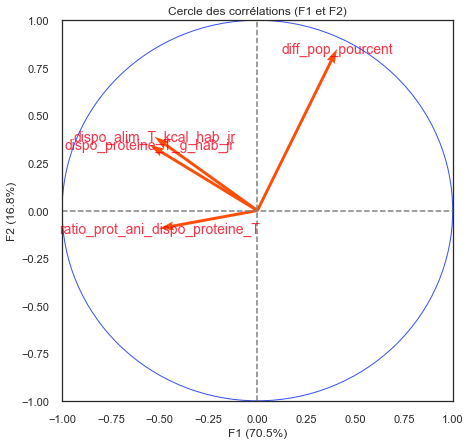

<Figure size 576x396 with 0 Axes>

In [207]:
# Cercle des corrélations sans EA
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
plt.savefig("cercle de corr gpeK.jpg")

In [208]:
# Composantes principales
pd.DataFrame(X_reduced, index=df_sans_deux_acp_gpe.index, columns=["F"+str(i+1) for i in range(2)])

,F1,F2
0,1.663790,-0.054530
1,1.316059,-0.303604
2,1.793089,-0.859558
3,3.042356,0.057492
4,3.054208,0.642780
...,...,...
168,-0.205370,-0.690665
169,-0.063001,-1.377802
170,-0.107952,0.171993
171,-1.875079,-1.263189


In [209]:
f1 = pca.components_[0]
f1

array([ 0.40818605, -0.52650979, -0.55090211, -0.50267132])

La composante F1 est une combinaison linéaire des variables telle que :

F1 = -0.40 * diff_pop_pourcent - 0.53 * dispo_alim_T_kcal_hab_jr - 0.55 * dispo_proteine_T_g_hab_jr - 0.50 * ratio_prot_ani_dispo_proteine_T

#### On observe que "dispo_alim_T_kcal_hab_jr est la variable qui contribue le plus à F1

#### La composante F2 est une combinaison linéaire des variables telle que :

In [210]:
f2 = pca.components_[1]
f2

array([ 0.84943642,  0.38785421,  0.34506315, -0.09464826])

F2 = 0.85 * **diff_pop_pourcent** + 0.39 * **dispo_alim_T_kcal_hab_jr** + 0.35 * **dispo_proteine_T_g_hab_jr** - 0.09 * **ratio_prot_ani_dispo_proteine_T**

#### La variable relative à la croissance de la population  est  fortement corrélée à la composante principale F2.

#### Vérification de la corrélation des variables entre elles

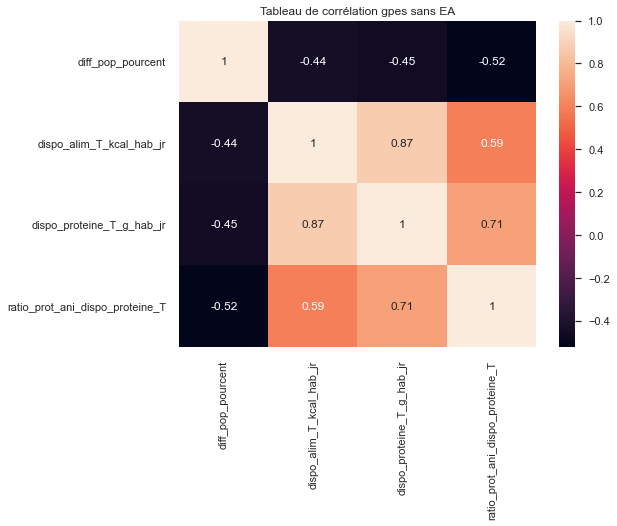

<Figure size 576x396 with 0 Axes>

In [211]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_sans_deux_acp.corr(method='pearson'), annot=True)
plt.title('Tableau de corrélation gpes sans EA')
plt.show()
plt.savefig("Tableau de corrélation gpesSansEA.jpg")


Remarque :
- les variables "dispo_alim_T_kcal_hab_jr" et "dispo_proteine_T_g_hab_jr" restent corrélées.

#### Projection des individus sur les 2 composantes principales

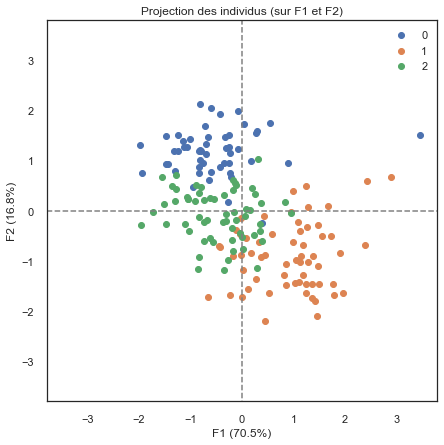

<Figure size 576x396 with 0 Axes>

In [212]:
# Projection des individus
X_projected = pca.transform(X_scaled_SD)
display_factorial_planes(X_scaled_SD, n_comp, pca, [(0,1)], illustrative_var=df_sans_deux_acp_gpe.clusters)
plt.show()
plt.savefig("proj individus gpeK.jpg")

#### Projection des centroïdes sur les 2 composantes principales

Représentation des centroïdes

In [213]:
X_centroide = kmb.cluster_centers_
X_centroide

array([[-0.53935401,  1.17608146,  1.20823418,  0.80256505],
       [ 0.91832247, -0.90041483, -0.96394752, -1.04304301],
       [-0.46738715, -0.08286639, -0.04621548,  0.372046  ]])

In [214]:
df_centro_SD = df_sans_deux_acp_gpe.groupby('clusters').mean().reset_index()
df_centro_SD = df_centro_SD.set_index('clusters')
df_centro_SD

,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
clusters,,,,
0,7.776295,3359.235294,105.192353,0.557480
1,26.604465,2451.114754,61.996393,0.259384
2,8.705859,2808.655738,80.246393,0.487944


In [215]:
# Xsd_pca = df_sans_deux_acp.values 
Xcsd = df_centro_SD.values
std_scalecsd = StandardScaler().fit(Xsd_pca)
X_scaledcsd = std_scalecsd.transform(Xcsd)

In [216]:
X_scaledcsd

array([[-0.53935401,  1.17608146,  1.20823418,  0.80256505],
       [ 0.91832247, -0.90041483, -0.96394752, -1.04304301],
       [-0.46738715, -0.08286639, -0.04621548,  0.372046  ]])

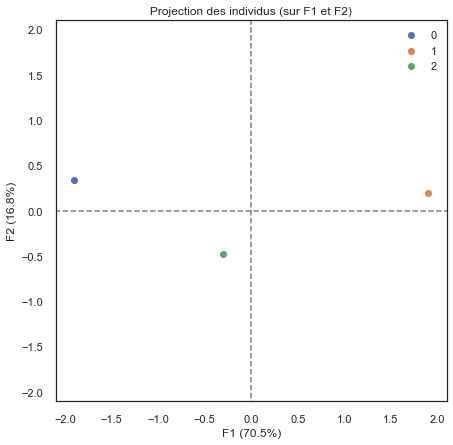

<Figure size 576x396 with 0 Axes>

In [217]:
# Projection des nouveaux centroïdes
X_projected_csd = pca.transform(X_scaledcsd)
display_factorial_planes(X_projected_csd, n_comp, pca, [(0,1)], illustrative_var=df_centro_SD.index)

plt.show()
plt.savefig("proj centroide gpeK.jpg")

In [218]:
# # Affichage des positions des centres de classes
# plt.figure()
# centroids = kmb.cluster_centers_
# centroids_projected = pca.transform(centroids)
# plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
# plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
# plt.show()

#### Projection des individus et des centroïdes sur les 2 composantes principales

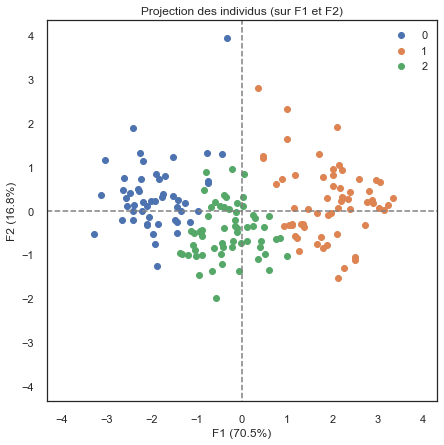

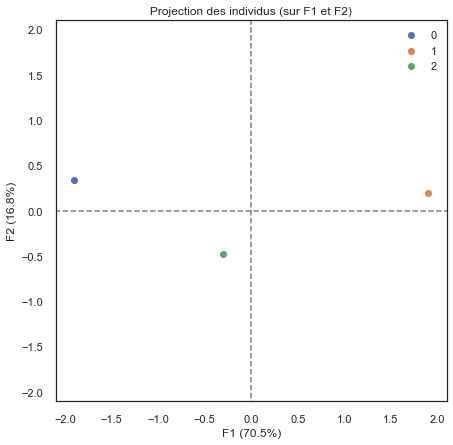

In [219]:
# Pour une meilleure visibilité, réunion des 3 représentations
# Projection des individus
X_projected = pca.transform(X_scaled_SD)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=df_sans_deux_acp_gpe.clusters)
plt.show()
# Projection des nouveaux centroïdes
X_projected_csd = pca.transform(X_scaledcsd)
display_factorial_planes(X_projected_csd, n_comp, pca, [(0,1)], illustrative_var=df_centro_SD.index)
plt.show()

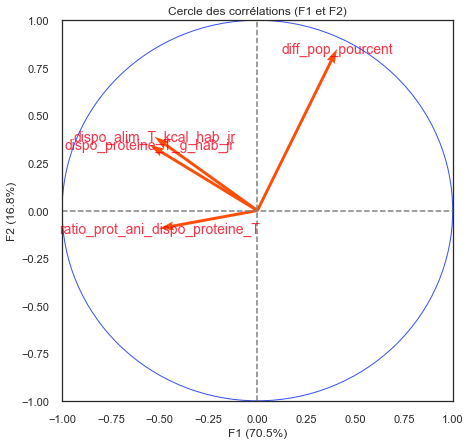

In [220]:
# Cercle des corrélations sans EA
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

### Conclusion

- En dépit du retrait des EA du dataframe, le groupe 2 (Allemagne...) reste le groupe qui a la plus forte disponibilité alimentaire donc le plus riche. Le gpe 0 (Angola...) est celui qui a la plus faible donc le plus pauvre. Il est certain que pour développer une activité, il est préférable de viser des pays aisés soit le groupe 2.

### Les groupes sont-ils distincts ?

In [221]:
df_sans_deux_acp_gpe.head(2)

,pays,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,clusters
0,République démocratique populaire lao,20.484072,2455.0,68.89,0.211642,1
1,Népal,13.336867,2672.0,68.99,0.165966,1


In [222]:
gpeSansEA0 = df_sans_deux_acp_gpe[df_sans_deux_acp_gpe['clusters']==0]['dispo_proteine_T_g_hab_jr']

In [223]:
gpeSansEA1 = df_sans_deux_acp_gpe[df_sans_deux_acp_gpe['clusters']==1]['dispo_proteine_T_g_hab_jr']

#### Variable gaussienne : dispo_proteine_T_g_hab_jr

Les groupes 0 et 1 ont le même ratio_prot_ani_dispo_proteine_T. Tests de variance et de moyennes sur ces 2 groupes

#### Test d' égalité des variances sur les groupes 0 et 1

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [224]:
stat, p_value = levene(gpeSansEA0, gpeSansEA1)
p_value

0.8632277045879362

La p_value est égale à 0.72 donc significativement supérieure au seuil alpha. HO ne peut pas être rejetée. Les variances des groupes 0 et1 sont égales.

#### Test d'égalité des moyennes (Student)

Les 2 groupes sont du même taille

Hypothèses :
- H0 : m4 = m5
- H1 : m4 != m5
- seuil alpha = 0.05

In [225]:
# Test de student sur les groupe 0 et 1
st.ttest_ind(gpeSansEA0.dropna(), gpeSansEA1.dropna(), equal_var=True)

Ttest_indResult(statistic=22.10046963171447, pvalue=2.912902265277504e-42)

La p_value (1.8.10-18) est inférieure au seuil alpha de 0.05 donc nous rejetons l'hypothèse HO. Les moyennes des 2 clusters (0 et 1) sont significativement différentes. Les clusters sont donc distincts.

### Variables supplémentaires (quantitatives)
#### Afin de confirmer le choix du groupe 2 (Allemangne...), on introduit une nouvelle variable qui est le PIB afin de confirmer notre hypothèse de "richesse" du groupe.
 
- Importation de données du PIB 2013 (http://www.fao.org/faostat/fr/#data)

In [226]:
# Importation et lecture de données
df_pib_2013 = pd.read_csv('df_pib_2013.csv', encoding=ENCODAGE)

In [227]:
df_pib_2013.tail(2)

,pays,PIB_hab_dollars
171,Monténégro,17333.0
172,Soudan,4083.7


In [228]:
df_pib_2013.shape

(173, 2)

In [229]:
#  Jointure avec le dataframe df_sans_deux_acp_gpe pour l'introduction de la variable PIB
df_pib_var = pd.merge(df_pib_2013,df_sans_deux_acp_gpe, how='left' )

In [230]:
# Suppression de la colonne 'clusters'
df_pib_var = df_pib_var.drop('clusters', axis=1)

In [231]:
df_pib_var.head(2)

,pays,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
0,Arménie,10691.3,-1.943347,2924.0,90.06,0.480124
1,Afghanistan,2264.3,32.168195,2087.0,58.26,0.209578


In [232]:
# Vérification des valeurs nulles
df_pib_var.isnull().sum()

pays                               0
PIB_hab_dollars                    0
diff_pop_pourcent                  0
dispo_alim_T_kcal_hab_jr           0
dispo_proteine_T_g_hab_jr          0
ratio_prot_ani_dispo_proteine_T    0
dtype: int64

In [233]:
#  Récupération des nouvelles variables quantitatives
vqs = df_pib_var.loc[:,'PIB_hab_dollars'].values

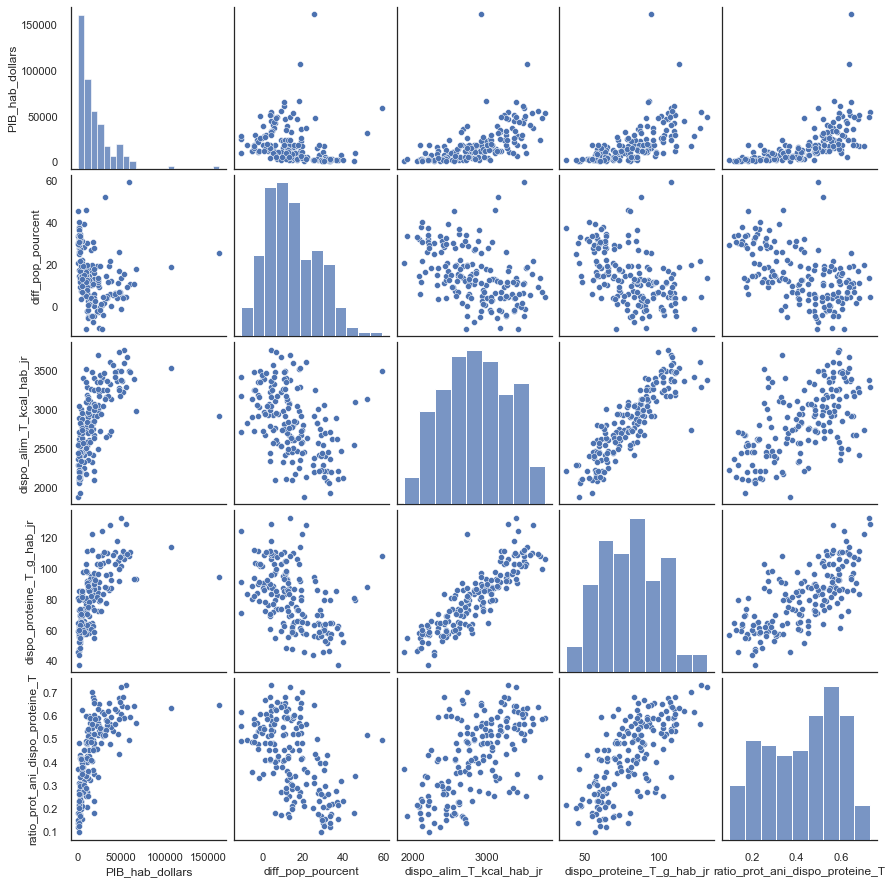

In [234]:
sns.pairplot(df_pib_var)

#### Etude de la variable "PIB_hab_dollars" (shewness, kurtosis...)

skewness PIB_hab_dollars:
 2.896668169652861
kurtosis PIB_hab_dollars:
 14.43909291685815


<Figure size 576x396 with 0 Axes>

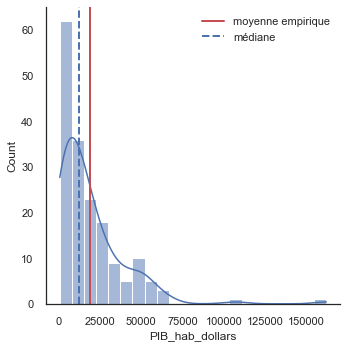

<Figure size 576x396 with 0 Axes>

In [235]:
# Visualisation de la variable PIB_hab_dollars
col = 'PIB_hab_dollars'
plt.figure()
sns.displot(df_pib_var[col], kde=True)     
plt.axvline(np.mean(df_pib_var[col]), color='r', linewidth=2, label='moyenne empirique')
plt.axvline(np.median(df_pib_var[col]), color='b', linewidth=2, linestyle='dashed', label='médiane')

plt.legend()
print(f'skewness {col}:\n',df_pib_var[col].skew())
print(f"kurtosis {col}:\n",df_pib_var[col].kurtosis())
plt.show()
plt.savefig("PIB_hab_dollars.jpg")

#### La variable 'PIB_hab_dollars' ne semble pas suivre une loi gaussienne. Vérification avec le **test de Kolmogorov-Smirnov**

#### Test de Kolmogorov-Smirnov sur 'PIB_hab_dollars' afin de vérifier la normalité ou non de la variable

Hypothèses :
- HO : suit une loi normale
- H1 : ne suit pas une loi normale
- seuil alpha 0.05

In [236]:
ks_2samp_test("PIB_hab_dollars", df_pib_var)

p_value :0.00011777376211985491


'HO rejetée, la variable PIB_hab_dollars ne suit pas une loi normale'

#### Nouvelle étude avec KMeans (PIB)

In [237]:
df_pib_var.head(1)

,pays,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
0,Arménie,10691.3,-1.943347,2924.0,90.06,0.480124


In [238]:
df_pib_var.columns

Index(['pays', 'PIB_hab_dollars', 'diff_pop_pourcent',
       'dispo_alim_T_kcal_hab_jr', 'dispo_proteine_T_g_hab_jr',
       'ratio_prot_ani_dispo_proteine_T'],
      dtype='object')

#### Nouveau dataframe incluant le PIB par habitant en dollars

In [239]:
# Création du nouveau dataframe
df_pib_var = df_pib_var.set_index('pays')

In [240]:
df_pib_var_pca = df_pib_var[['PIB_hab_dollars', 'diff_pop_pourcent',
       'dispo_alim_T_kcal_hab_jr', 'dispo_proteine_T_g_hab_jr',
       'ratio_prot_ani_dispo_proteine_T']]

In [241]:
df_pib_var_pca.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,,
Arménie,10691.3,-1.943347,2924.0,90.06,0.480124
Afghanistan,2264.3,32.168195,2087.0,58.26,0.209578


#### Clustering

In [242]:
# préparation des données pour le clustering
Xpic = df_pib_var_pca.values
names = df_pib_var_pca.index

In [243]:
#  Standardisation des données
scaler = StandardScaler()
X_scaledPic = scaler.fit_transform(Xpic)

In [244]:
# Vérification de la standardisation
X_scaledPic.mean(axis=0)

array([ 4.10718344e-17, -2.15627131e-16, -7.18757103e-17,  4.20986303e-16,
        1.54019379e-16])

In [245]:
# Vérification de la standardisation
X_scaledPic.std(axis=0)

array([1., 1., 1., 1., 1.])

In [246]:
nb_cluster = 3

In [247]:
from sklearn import cluster
res = cluster.KMeans(n_clusters=nb_cluster)
res.fit(X_scaledPic)

KMeans(n_clusters=3)

#### Elbow method

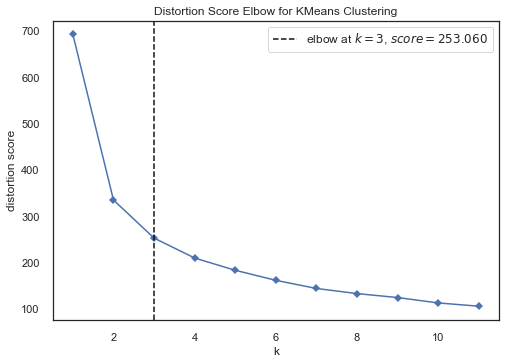

<Figure size 576x396 with 0 Axes>

In [248]:
# Recherche du nombre de clusters optimal
# Décroissance de l'inertie interclasse (k:clusters)
visualizer = KElbowVisualizer(res, k=(1,12), timings=False)
visualizer.fit(X_scaledSd)
visualizer.show()  
plt.savefig("elbow PIB_hab_dollars.jpg")

Le nombre de clusters optimal est de 3

#### Clustering avec 3 clusters

In [249]:
from sklearn import cluster
resBis = cluster.KMeans(n_clusters=nb_cluster)
resBis.fit(X_scaledPic)

KMeans(n_clusters=3)

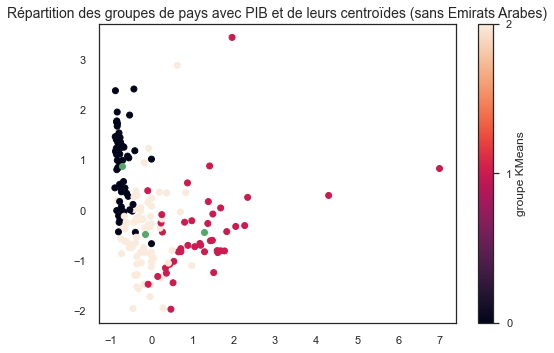

<Figure size 576x396 with 0 Axes>

In [250]:
# Repr2sentation des individus et des clusters (en vert)sur 2 variables 
resBis.predict(X_scaledPic)
plt.scatter(X_scaledPic[:,0], X_scaledPic[:,1], c = resBis.predict(X_scaledPic))
plt.colorbar(ticks=range(6), label='groupe KMeans')
plt.scatter(resBis.cluster_centers_[:,0], resBis.cluster_centers_[:,1], c='g')
plt.title('Répartition des groupes de pays avec PIB et de leurs centroïdes (sans Emirats Arabes)', size=14)
plt.show()
plt.savefig("Répartition des groupes de pays avec PIB  et de leurs centroïdes (sans Emirats Arabes).jpg")

In [251]:
# Calcul des moyennes par groupe
gb = df_pib_var_pca.groupby(resBis.labels_)

In [252]:
# Ajout des groupes au dataframe
df_pib_var_pca_clt = df_pib_var_pca.copy()
df_pib_var_pca_clt['cluster'] = resBis.labels_ 

In [253]:
# Pour avoir l'inventaire du groupe (ATTENTION le groupe "Allemagne" devient le groupe 1 (et non plus le 2))
df_pibGpe = df_pib_var_pca_clt[df_pib_var_pca_clt['cluster']==1]
df_pibGpe.index.sort_values()

Index(['Allemagne', 'Arabie saoudite', 'Argentine', 'Australie', 'Autriche',
       'Belgique', 'Brunéi Darussalam', 'Canada', 'Chine - RAS de Hong-Kong',
       'Chine - RAS de Macao', 'Danemark', 'Espagne', 'Estonie', 'Finlande',
       'France', 'Fédération de Russie', 'Grèce', 'Irlande', 'Islande',
       'Israël', 'Italie', 'Kazakhstan', 'Koweït', 'Lituanie', 'Luxembourg',
       'Maldives', 'Malte', 'Monténégro', 'Norvège', 'Nouvelle-Zélande',
       'Pays-Bas', 'Pologne', 'Portugal', 'Roumanie',
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'République de Corée', 'Slovénie', 'Suisse', 'Suède', 'Tchéquie',
       'Turquie', 'États-Unis d'Amérique'],
      dtype='object', name='pays')

In [254]:
# Calcul des moyennes par groupe
df_pib_varK_cltS = df_pib_var_pca_clt.groupby(resBis.labels_)

In [255]:
df_pib_varK_cltS.size()

0    59
1    42
2    72
dtype: int64

Remarque : les groupes sont distribués différemment avec l'introduction de la variable "PIB_hab_dollars".

In [256]:
# Moyenne par classe
df_pib_varK_cltS.mean()

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster
0,4497.743441,26.104487,2429.135593,61.253898,0.253152,0
1,45210.423810,9.168339,3371.238095,106.744048,0.585875,1
2,15582.201237,8.684526,2878.555556,82.560972,0.478830,2


Remarque :
- Gpe 1 (Allemagne...) : plus FORTS "PIB_hab_dollars", "dispo_alim_T_kcal_hab_jr", "dispo_proteine_T_g_hab_jr", "ratio_prot_ani_dispo_proteine_T" : pays riches
- Gpe 0 (Angola...) : plus FAIBLE "PIB_hab_dollars", plus FORT "diff_pop_pourcent", plus FAIBLE "ratio_prot_ani_dispo_proteine_T", "dispo_proteine_T_g_hab_jr", "dispo_alim_T_kcal_hab_jr" : pays pauvres
- Gpe 1 (Albanie...) : données moyennes

In [257]:
# Position des centroïdes
pos_centroide = resBis.cluster_centers_
pos_centroide

array([[-0.70933403,  0.87961417, -0.95067208, -1.00128514, -1.0816288 ],
       [ 1.28269984, -0.43158198,  1.20352691,  1.28626377,  0.97836875],
       [-0.16698174, -0.46903879,  0.0769656 ,  0.07017702,  0.3156196 ]])

#### ACP sur les groupes

In [258]:
# Récupération des colonnes pertinentes
df_pib_varK_cltS_acp = df_pib_varK_cltS[['PIB_hab_dollars', 'diff_pop_pourcent',
       'dispo_alim_T_kcal_hab_jr', 'dispo_proteine_T_g_hab_jr',
       'ratio_prot_ani_dispo_proteine_T']]

In [259]:
# préparation des données pour l'ACP 
df_pib_varK_cltS_acp = df_pib_varK_cltS_acp.fillna(df_dispo_gpe_pca.mean())
Xpic_pca = df_pib_varK_cltS_acp.values
names = df_pib_varK_cltS_acp.index
features = df_pib_varK_cltS_acp.columns

In [260]:
# Centrage et réduction des données
std_scale = StandardScaler().fit(Xpic_pca)
X_scaled_Pic = std_scale.transform(Xpic_pca)

In [261]:
# Nombre de composantes
n_comp = 5

In [262]:
# Calcul des composantes principales
varS_pca = decomposition.PCA(n_components=n_comp)
varS_pca.fit(X_scaled_Pic)

PCA(n_components=5)

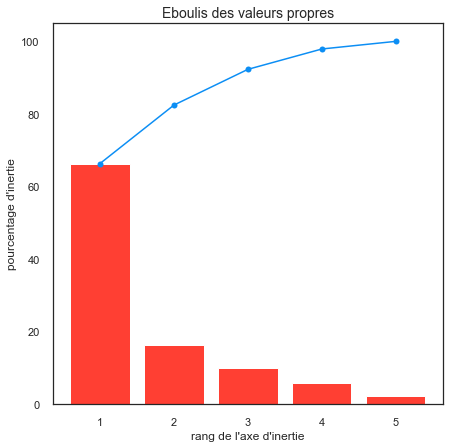

<Figure size 576x396 with 0 Axes>

In [263]:
# Eboulis des valeurs propres
display_scree_plot(varS_pca)
plt.savefig("eboulis PIB_hab_dollars.jpg")

2 composantes suffisent à l'ACP

Ré entrainement du modèle avec le nombre de composantes trouvées précédement.

In [264]:
n_comp = 2

In [265]:
# Calcul des composantes principales
varS_pcaB = decomposition.PCA(n_components=n_comp)
X_reduced = varS_pcaB.fit_transform(X_scaled_Pic)

In [266]:
# Vecteurs propres
varS_pcaB.components_

array([[ 0.42107514, -0.33499838,  0.48265248,  0.50662237,  0.46994911],
       [ 0.51264464,  0.84547893,  0.0969524 ,  0.09656066, -0.06030854]])

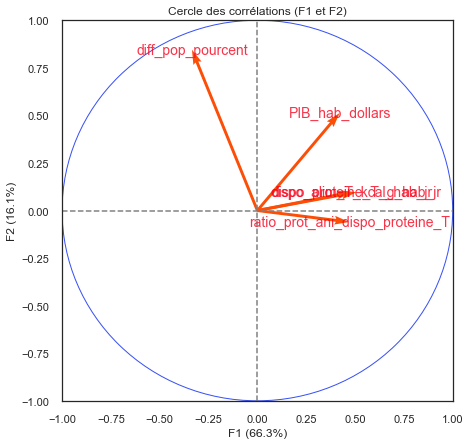

In [267]:
# Cercle des corrélations avec PIB
pcs = varS_pcaB.components_
display_circles(pcs, n_comp, varS_pcaB, [(0,1)], labels = np.array(features))

#### Interprétation chiffrée (PIB)

In [268]:
# Calcul des composantes
df_composante = pd.DataFrame(X_reduced, index=df_pib_varK_cltS_acp.index, columns=["F"+str(i+1) for i in range(2)])

In [269]:
df_composante.head(2)

F1        F2
  pays                           
0 Afghanistan -2.851709  0.523210
  Angola      -2.187113  1.172695

In [270]:
varS_pcaB.components_

array([[ 0.42107514, -0.33499838,  0.48265248,  0.50662237,  0.46994911],
       [ 0.51264464,  0.84547893,  0.0969524 ,  0.09656066, -0.06030854]])

In [271]:
f1 = varS_pcaB.components_[0]
f1

array([ 0.42107514, -0.33499838,  0.48265248,  0.50662237,  0.46994911])

- La composante F1 est une combinaison linéaire des variables telle que :

F1 = 0.42 * "PIB_hab_dollars" - 0.33 * "diff_pop_pourcent" + 0.5 * "dispo_alim_T_kcal_hab_jr" + 0.5 * "dispo_proteine_T_g_hab_jr" + 0.47 * "ratio_prot_ani_dispo_proteine_T"

In [272]:
f2 = varS_pcaB.components_[1]
f2

array([ 0.51264464,  0.84547893,  0.0969524 ,  0.09656066, -0.06030854])

#### On observe que "dispo_alim_T_kcal_hab_jr est la variable qui contribue le plus à F1. 

- La composante F2 est une combinaison linéaire des variables telle que :

F2 = 0.51 * "PIB_hab_dollars" + 0.85 * "diff_pop_pourcent" + 0.09 * "dispo_alim_T_kcal_hab_jr" + 0.09 * "dispo_proteine_T_g_hab_jr" -0.06 * "ratio_prot_ani_dispo_proteine_T"

#### On observe que "diff_pop_pourcent" et "PIB_hab_dollars" sont les variables qui contribuent le plus à F2

#### Les variables liées à l'alimentation se projettent sur F1 .

#### Vérification de la corrélation des variables entre elles (PIB)

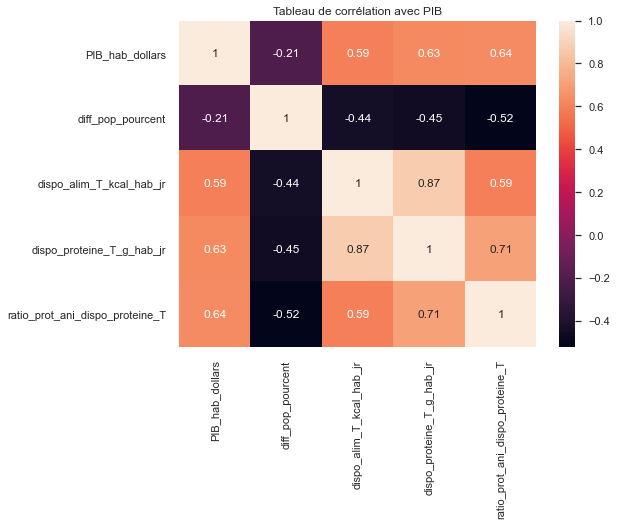

<Figure size 576x396 with 0 Axes>

In [273]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_pib_varK_cltS_acp.corr(method='pearson'), annot=True)
plt.title('Tableau de corrélation avec PIB')
plt.show()
plt.savefig("Tableau de corrélation avec PIB.jpg")


#### Remarque : le PIB est corrélé avec les variables alimentaires ce qui est parfaitement normal.

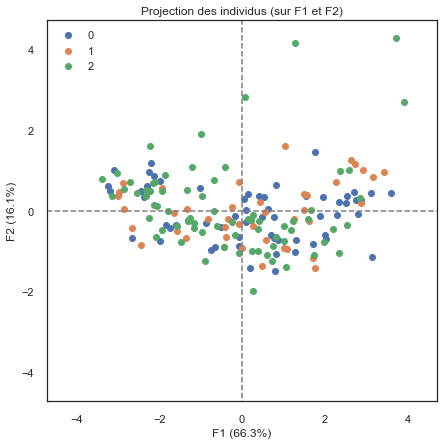

In [274]:
# Projection des individus (PIB)
X_projected_pic = varS_pcaB.transform(X_scaled_Pic)
display_factorial_planes(X_projected_pic, n_comp, varS_pcaB, [(0,1)], illustrative_var=df_pib_var_pca_clt.cluster)
plt.show()

In [275]:
# Position des centroïdes : pos_centroide = resBis.cluster_centers_
pos_centroide

array([[-0.70933403,  0.87961417, -0.95067208, -1.00128514, -1.0816288 ],
       [ 1.28269984, -0.43158198,  1.20352691,  1.28626377,  0.97836875],
       [-0.16698174, -0.46903879,  0.0769656 ,  0.07017702,  0.3156196 ]])

In [276]:
df_pib_var_pca_clt.cluster.unique()

array([2, 0, 1])

Dataframe des centroïdes :

In [277]:
df_pos_centroïdes = pd.DataFrame(pos_centroide, index=df_pib_var_pca_clt.cluster.unique(), 
                                 columns=['PIB_hab_dollars', 'diff_pop_pourcent', 'dispo_alim_T_kcal_hab_jr',
       'dispo_proteine_T_g_hab_jr', 'ratio_prot_ani_dispo_proteine_T'])

In [278]:
df_pos_centroïdes.head(4)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
2,-0.709334,0.879614,-0.950672,-1.001285,-1.081629
0,1.282700,-0.431582,1.203527,1.286264,0.978369
1,-0.166982,-0.469039,0.076966,0.070177,0.315620


In [279]:
df_centroPic = df_pib_varK_cltS.mean().set_index('cluster')
df_centroPic.head(4)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
cluster,,,,,
0,4497.743441,26.104487,2429.135593,61.253898,0.253152
1,45210.423810,9.168339,3371.238095,106.744048,0.585875
2,15582.201237,8.684526,2878.555556,82.560972,0.478830


Remarque : le gpe 1 est le groupe avec le PIB par habitant le plus élevé (44989 $) et les variables alimentaires dont les données sont les plus élevées (ex : dispo_alim_T_kcal_hab_jr = 3366 kcal/hab/jour).

#### Projection des centroïdes

In [280]:
# Xsd_pca = df_sans_deux_acp.values 
XcPi = df_centroPic.values
std_scalecpi = StandardScaler().fit(Xpic_pca)
X_scaledpi = std_scalecpi.transform(XcPi)

In [281]:
X_scaledpi

array([[-0.70933403,  0.87961417, -0.95067208, -1.00128514, -1.0816288 ],
       [ 1.28269984, -0.43158198,  1.20352691,  1.28626377,  0.97836875],
       [-0.16698174, -0.46903879,  0.0769656 ,  0.07017702,  0.3156196 ]])

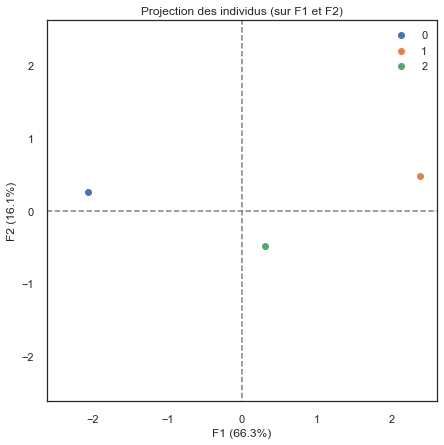

In [282]:
# Projection des nouveaux centroïdes
X_projected_pi = varS_pca.transform(X_scaledpi)
display_factorial_planes(X_projected_pi, n_comp, varS_pca, [(0,1)], illustrative_var=df_centroPic.index)
plt.show()

#### Pour une meilleure visualisation : réunion de la projection des centroïdes et du cercle de corrélation 

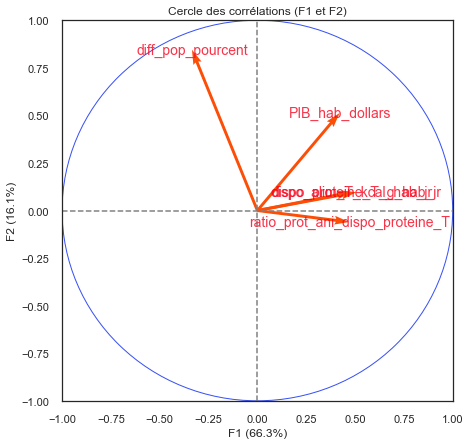

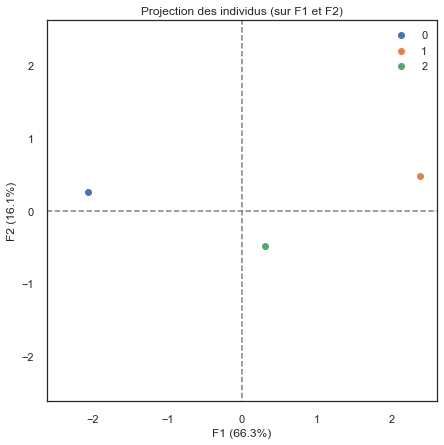

In [283]:
# Cercle des corrélations avec PIB
pcs = varS_pcaB.components_
display_circles(pcs, n_comp, varS_pcaB, [(0,1)], labels = np.array(features))
# plt.subplot(211)
# Projection des centroïdes (var : PIB)
X_projected_pi = varS_pca.transform(X_scaledpi)
display_factorial_planes(X_projected_pi, n_comp, varS_pca, [(0,1)], illustrative_var=df_centroPic.index)
plt.show()


In [284]:
# # Affichage des positions des centres de classes
# plt.figure()
# # centroids = km.cluster_centers_
# centroids_projected = varS_pca.transform(pos_centroide)
# plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
# plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids_projected)))
# plt.show()

#### Conclusion : le groupe 1 est effectivement le groupe le plus aisé tant au niveau alimentaire qu'au niveau pécunière. Le choix des pays à prospecter se fera sur ce groupe. L'axe F2 représente le PIB mais la diff_pop  mieux projetée (089 contre 0.51) => gpe0 plus haut sur F2 car diff_pop plus grande que pour le groupe 2. 

### Les groupes sont-ils vraiment distincts ? (tests d'égalité des variances et des moyennes)

In [285]:
df_pib_var_pca_clt.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster
pays,,,,,,
Arménie,10691.3,-1.943347,2924.0,90.06,0.480124,2
Afghanistan,2264.3,32.168195,2087.0,58.26,0.209578,0


####  Visualisation des groupes par boxplot

- Variable : **"dispo_proteine_T_g_hab_jr"**-- variable suivant la loi gaussienne sur tous les tests

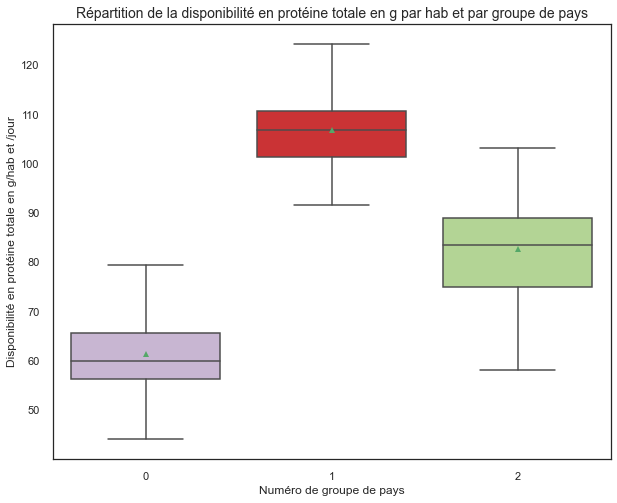

<Figure size 576x396 with 0 Axes>

In [286]:
# Visualisation de la variable dispo_proteine_T_g_hab_jr en fonction des groupes
plt.figure(figsize=(10,8))
sns.boxplot(x='cluster', y='dispo_proteine_T_g_hab_jr', data=df_pib_var_pca_clt, palette= 'Paired_r', showmeans=True, showfliers=False)
plt.title('Répartition de la disponibilité en protéine totale en g par hab et par groupe de pays', size=14)
plt.ylabel('Disponibilité en protéine totale en g/hab et /jour', size= 12)
plt.xlabel('Numéro de groupe de pays', size=12)
plt.show()
plt.savefig("pib variable.jpg")

Test sur la variance

Nous allons tester les groupes avec un levene's test (test d'homogénéïté des variances). Le levene test est plus "souple" concernant la normalité des distributions (par rapport à un Bartlett’s Test)

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [287]:
gpe0 = df_pib_var_pca_clt[df_pib_var_pca_clt['cluster']==0]['dispo_proteine_T_g_hab_jr']

In [288]:
gpe1 = df_pib_var_pca_clt[df_pib_var_pca_clt['cluster']==1]['dispo_proteine_T_g_hab_jr']

In [289]:
gpe2 = df_pib_var_pca_clt[df_pib_var_pca_clt['cluster']==2]['dispo_proteine_T_g_hab_jr']

In [290]:
# Test de levene sur les gpes 0, 1 et 2
stat, p_value = levene(gpe0, gpe1, gpe2)
p_value

0.6870215383078139

La p_value est supérieure au seuil alpha. HO ne peut pas être rejetée. **Les variances des 3 groupes sont donc similaires**.

#### Test d'Anova

Hypothèses :

- H0 : les moyennes des groupes sont égales
- H1 : les moyennes des groupes sont différentes
- seuil alpha : 0.05

On ramène les groupes à la même taille

In [291]:
gpe0.shape[0]

59

In [292]:
gpe1.shape[0]

42

In [293]:
gpe2.shape[0]

72

In [294]:
def sample_groupe(gpe0, gpe1, gpe2) :    
    taille_groupe = [gpe0.shape[0], gpe1.shape[0], gpe2.shape[0]]    
    reference_sample = min(taille_groupe)
    return reference_sample        

In [295]:
reference_sample = sample_groupe(gpe0, gpe1, gpe2)

In [296]:
# Echantillon avec nb d'observation du groupe 2
gpe0_sample = gpe0.sample(reference_sample)

In [297]:
gpe0_sample.shape

(42,)

In [298]:
# Echantillon avec nb d'observation du groupe 2
gpe1_sample = gpe1.sample(reference_sample)

In [299]:
gpe1_sample.shape

(42,)

In [300]:
gpe2_sample = gpe2.sample(reference_sample)

In [301]:
gpe2_sample.shape

(42,)

#### Test de l'égalité des variances sur les groupes 1  et  2

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [302]:
# Test de levene sur les gpes 1 et 2
stat, p_value = levene(gpe1_sample, gpe2_sample)
p_value

0.5158261913306728

La p_value (0.71) est significativement supérieure au seuil alpha. HO ne peut pas être rejetée. **Les variances des  groupes 1 et 2 sont donc similaires**.

#### Test d'égalité des moyennes

Test d'anova pour gpes 0, 1, 2

In [303]:
fvalue, pvalue = stats.f_oneway(gpe0_sample, gpe1_sample, gpe2_sample)
pvalue

3.1251019763243256e-40

La p_value est significativement inférieure au seuil alpha. HO est donc rejetée. Les moyennes des groupes sont significativement différentes. **Les groupes sont donc distincts**. Ils n'ont pas la même distribution.

#### Test de Student sur les groupes 1 et 2

In [304]:
st.stats.ttest_ind(gpe1_sample.dropna(),gpe2_sample.dropna(), equal_var=True)

Ttest_indResult(statistic=10.217952210696643, pvalue=2.7737284849355127e-16)

La p_value (2.17.10-16) est significativement inférieure au seuil alpha. HO est donc rejetée. Les moyennes des groupes 1 et 2 sont significativement différentes. **Les groupes sont donc distincts**.

### Analyse du groupe le plus "riche" (groupe choisi pour la recherche de pays à prospecter)

In [305]:
df_centroPic

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
cluster,,,,,
0,4497.743441,26.104487,2429.135593,61.253898,0.253152
1,45210.423810,9.168339,3371.238095,106.744048,0.585875
2,15582.201237,8.684526,2878.555556,82.560972,0.478830


In [306]:
cluster_grand_PIB = df_centroPic['PIB_hab_dollars'].argmax()

In [307]:
df_pib_var_pca_clt.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster
pays,,,,,,
Arménie,10691.3,-1.943347,2924.0,90.06,0.480124,2
Afghanistan,2264.3,32.168195,2087.0,58.26,0.209578,0


In [308]:
df_gpe_suggere = df_pib_var_pca_clt[df_pib_var_pca_clt["cluster"]==cluster_grand_PIB]

In [309]:
df_gpe_suggere.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster
pays,,,,,,
Argentine,24424.3,9.154596,3226.0,102.60,0.652339,1
Australie,47192.1,16.989926,3278.0,106.26,0.674666,1


In [310]:
df_gpe_suggere.describe()

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.0
mean,45210.423810,9.168339,3371.238095,106.744048,0.585875,1.0
std,24785.335463,11.292616,212.290621,10.301295,0.077457,0.0
min,17132.400000,-10.686797,2733.000000,87.410000,0.335738,1.0
25%,29792.425000,4.072715,3255.000000,101.407500,0.545470,1.0
50%,43222.150000,6.570202,3377.500000,106.870000,0.592111,1.0
75%,51812.875000,13.246621,3496.750000,110.672500,0.636885,1.0
max,161939.000000,59.215501,3770.000000,133.060000,0.731386,1.0


#### Le groupe  comporte 43 pays. La population est en croissance (+10%). Le PIB par habitant est important.  Ils ne sont pas végan (ratio prot ani / prot totale > 0.58). 

Les pays "idéaux" seraient avec un PIB élevé, une population en croissance et carnivore.

In [311]:
df_gpe_PibF = df_gpe_suggere.sort_values(["PIB_hab_dollars", "diff_pop_pourcent", "ratio_prot_ani_dispo_proteine_T"], ascending=False)

In [312]:
df_pays_proposes = df_gpe_PibF.reset_index().iloc[:15, :]
df_pays_proposes.pays.values

array(['Chine - RAS de Macao', 'Luxembourg', 'Brunéi Darussalam',
       'Suisse', 'Norvège', 'Koweït', "États-Unis d'Amérique",
       'Chine - RAS de Hong-Kong', 'Irlande', 'Autriche', 'Pays-Bas',
       'Danemark', 'Allemagne', 'Islande', 'Suède'], dtype=object)

il serait intéressant de connaître les préférences en viande. (importation)

### Affichage des pays proposés

In [1]:
import folium

In [2]:
c= folium.Map(location=[47.255982,-1.524715],zoom_start=2, world_copy_jump=False, no_wrap=False)
# Macao
folium.Marker([22.2013615,113.54739000000001], icon=folium.Icon(color="orange")).add_to(c)
# 'Luxembourg'
folium.Marker([49.8157635,6.1315139999999815], icon=folium.Icon(color="orange")).add_to(c)
# Brunéi Darussalam
folium.Marker([4.525125,114.715443], icon=folium.Icon(color="orange")).add_to(c)
# 'Suisse'
folium.Marker([46.8155135,8.224471999999992], icon=folium.Icon(color="orange")).add_to(c)
# 'Norvège'
folium.Marker([64.58301349999999,17.86410976037601], icon=folium.Icon(color="orange")).add_to(c)
# 'Koweït'
folium.Marker([29.310278,47.493515], icon=folium.Icon(color="orange")).add_to(c)
# États-Unis
folium.Marker([36.966428,-95.844032], icon=folium.Icon(color="orange")).add_to(c)
# Hong-Kong'
folium.Marker([22.356514,114.13625300000001], icon=folium.Icon(color="orange")).add_to(c)
# 'Irlande'
folium.Marker([53.4197505,-8.24047250000001], icon=folium.Icon(color="orange")).add_to(c)
# 'Autriche'
folium.Marker([47.6975425,13.34931899999998], icon=folium.Icon(color="orange")).add_to(c)
# 'Pays-Bas'
folium.Marker([52.133057,5.29525000000001], icon=folium.Icon(color="orange")).add_to(c)
# 'Danemark'
folium.Marker([56.15540300000001,11.617222500000025], icon=folium.Icon(color="orange")).add_to(c)
# 'Allemagne'
folium.Marker([51.1657065,10.452764000000002], icon=folium.Icon(color="orange")).add_to(c)
# 'Islande'
folium.Marker([64.9639415,-19.021169499999985], icon=folium.Icon(color="orange")).add_to(c)
# 'Suède'
folium.Marker([62.199805999999995,17.63749324195902], icon=folium.Icon(color="orange")).add_to(c)


c.save('P5carte_pays_proposes.html')

### Juste pour voir...... Autre méthode : ACP sur le groupe choisi

In [313]:
df_gpe_sug = df_gpe_suggere.copy()

In [314]:
df_gpe_sug.shape

(42, 6)

In [315]:
# Suppression de la col "cluster"
df_gpe_sug = df_gpe_sug.drop('cluster', axis=1)

In [316]:
df_gpe_sug.shape

(42, 5)

In [317]:
df_gpe_sug.head(3)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,,
Argentine,24424.3,9.154596,3226.0,102.60,0.652339
Australie,47192.1,16.989926,3278.0,106.26,0.674666
Autriche,53289.4,4.335544,3770.0,106.20,0.591902


#### Description groupe proposé

In [318]:
df_gpe_sug.describe()

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,45210.423810,9.168339,3371.238095,106.744048,0.585875
std,24785.335463,11.292616,212.290621,10.301295,0.077457
min,17132.400000,-10.686797,2733.000000,87.410000,0.335738
25%,29792.425000,4.072715,3255.000000,101.407500,0.545470
50%,43222.150000,6.570202,3377.500000,106.870000,0.592111
75%,51812.875000,13.246621,3496.750000,110.672500,0.636885
max,161939.000000,59.215501,3770.000000,133.060000,0.731386


#### Standartisation des données

In [319]:
# préparation des données pour le clustering
XgpeSug = df_gpe_sug.values
names = df_gpe_sug.index

In [320]:
#  Standardisation des données
scalerSug = StandardScaler()
X_scaledSugc = scalerSug.fit_transform(XgpeSug)

####  Kmeans

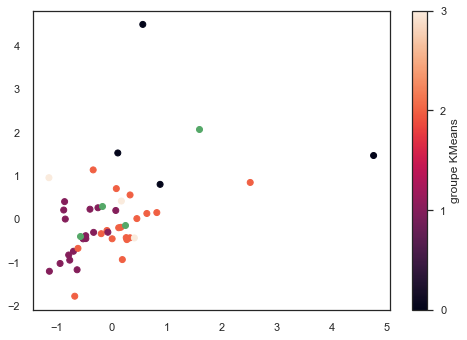

In [321]:
modelSug = KMeans(n_clusters = 4)
modelSug.fit(X_scaledSugc)
modelSug.predict(X_scaledSugc)
plt.scatter(X_scaledSugc[:,0], X_scaledSugc[:,1], c = modelSug.predict(X_scaledSugc))
plt.colorbar(ticks=range(6), label='groupe KMeans')
plt.scatter(modelSug.cluster_centers_[:,0], modelSug.cluster_centers_[:,1], c='g')

#### Clustering elbow method

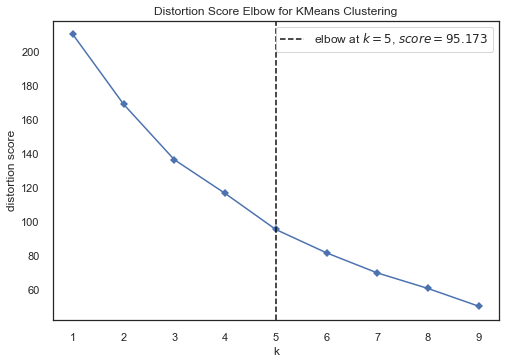

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [322]:
visualizer = KElbowVisualizer(modelSug, k=(1,10), timings=False)
visualizer.fit(X_scaledSugc)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

#### Le nombre de groupe donné par la méthode du coude est de 4 . 

#### Nouveau clustering avec 4 groupes

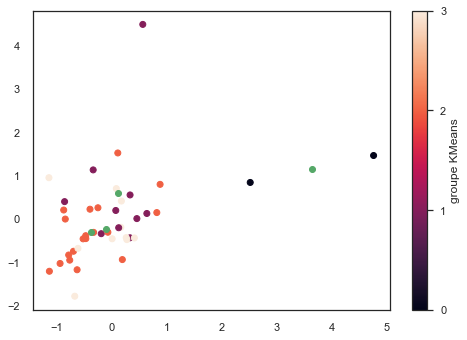

In [323]:
modelSugB = KMeans(n_clusters = 4)
modelSugB.fit(X_scaledSugc)
modelSugB.predict(X_scaledSugc)
plt.scatter(X_scaledSugc[:,0], X_scaledSugc[:,1], c = modelSugB.predict(X_scaledSugc))
plt.colorbar(ticks=range(6), label='groupe KMeans')
plt.scatter(modelSugB.cluster_centers_[:,0], modelSugB.cluster_centers_[:,1], c='g')

In [324]:
modelSugB.labels_

array([2, 3, 1, 2, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 1, 1, 2, 2, 1, 3, 0, 3,
       2, 3, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 1, 0, 2])

In [325]:
# Intégration des groupes dans le dataframe
df_gpe_sugG = df_gpe_sug.copy()
df_gpe_sugG['cluster_sug'] = modelSugB.labels_

In [326]:
df_gpe_sugG.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster_sug
pays,,,,,,
Argentine,24424.3,9.154596,3226.0,102.60,0.652339,2
Australie,47192.1,16.989926,3278.0,106.26,0.674666,3


In [327]:
# Effectif par groupes
df_gpe_sugG.groupby('cluster_sug').size()

cluster_sug
0     2
1    10
2    19
3    11
dtype: int64

Remarque : groupes hétérogènes

#### ACP sur les groupes

In [328]:
df_gpe_sugG.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster_sug
pays,,,,,,
Argentine,24424.3,9.154596,3226.0,102.60,0.652339,2
Australie,47192.1,16.989926,3278.0,106.26,0.674666,3


In [329]:
df_gpe_sug_acp = df_gpe_sugG.drop('cluster_sug', axis=1)

In [330]:
# préparation des données pour l'ACP
df_gpe_sug_acp = df_gpe_sug_acp.fillna(df_gpe_sug.mean())
Xsug_pca = df_gpe_sug_acp.values
names = df_gpe_sug_acp.index
features = df_gpe_sug_acp.columns

In [331]:
df_gpe_sug_acp.head(2)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
pays,,,,,
Argentine,24424.3,9.154596,3226.0,102.60,0.652339
Australie,47192.1,16.989926,3278.0,106.26,0.674666


In [332]:
cluster_sug = modelSugB.labels_
cluster_sug

array([2, 3, 1, 2, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 1, 1, 2, 2, 1, 3, 0, 3,
       2, 3, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 1, 0, 2])

In [333]:
df_gpe_sugCl = pd.DataFrame({'cluster_sug': cluster_sug, 'pays': names })
df_gpe_sugCl = df_gpe_sugCl.sort_values('cluster_sug')
df_gpe_sugCl.head(2)

,cluster_sug,pays
20,0,Chine - RAS de Macao
40,0,Luxembourg


In [334]:
df_gpe_sug_acpGpe = pd.merge(df_gpe_sug_acp, df_gpe_sugCl, on='pays', how='left')

In [335]:
df_gpe_sug_acpGpe.head(2)

,pays,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster_sug
0,Argentine,24424.3,9.154596,3226.0,102.60,0.652339,2
1,Australie,47192.1,16.989926,3278.0,106.26,0.674666,3


In [336]:
# Centrage et réduction des données
std_scaleGS = StandardScaler().fit(Xsug_pca)
X_scaled_sugG = std_scaleGS.transform(Xsug_pca)

In [337]:
# Nombre de composantes
n_comp = 5

In [338]:
# Calcul des composantes principales
pca_sugG = decomposition.PCA(n_components=n_comp)
pca_sugG.fit(X_scaled_sugG)

PCA(n_components=5)

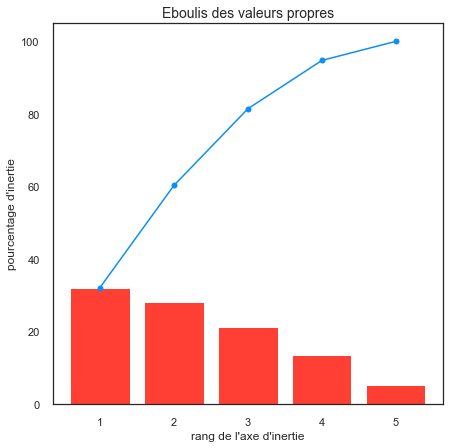

In [339]:
# Eboulis des valeurs propres
display_scree_plot(pca_sugG)

In [340]:
# A partir de quelle composante on atteind 95% de variance
np.argmax(np.cumsum(pca_sugG.explained_variance_ratio_)>0.95)

4

#### Les variables semblent très peu liées entre elles

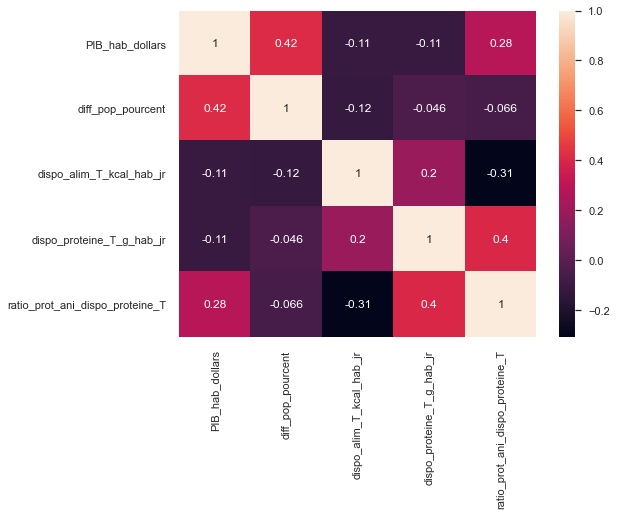

In [341]:
# tableau de covariance
plt.figure(figsize=(8, 6))
sns.heatmap(df_gpe_sug_acp.corr(method='pearson'), annot=True)
plt.show()

#### En effet, les variables décrivant les groupes sont indépendantes entre elles.  L'inertie totale est quasiment répartie équitablement entre les différents axes. Il n'est pas pertinent de procéder à une ACP.

#### ACP juste pour voir....

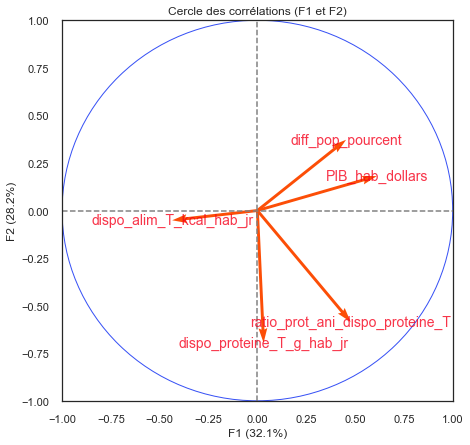

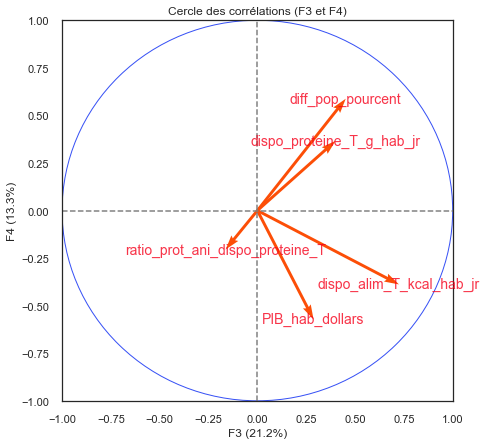

In [342]:
# Cercle des corrélations sans EA
pcs = pca_sugG.components_
display_circles(pcs, n_comp, pca_sugG, [(0,1), (2,3)], labels = np.array(features))

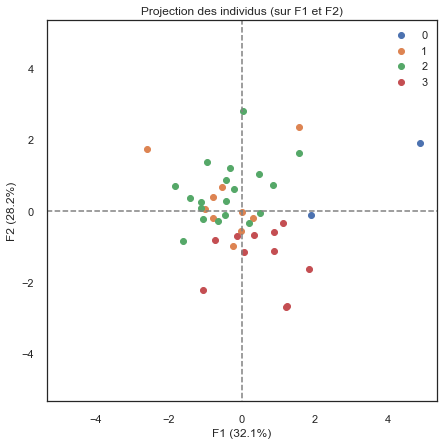

In [343]:
# Projection des individus
X_projected = pca_sugG.transform(X_scaled_sugG)
display_factorial_planes(X_projected, n_comp, pca_sugG, [(0,1)], illustrative_var=df_gpe_sug_acpGpe.cluster_sug)
plt.show()

#### Centroïdes

In [344]:
# Position des centroïdes
pos_cent_sug = modelSugB.cluster_centers_
pos_cent_sug

array([[ 3.64320382,  1.1530695 , -0.68528905, -0.25044874,  0.70392193],
       [ 0.11148363,  0.59347335,  1.17074659,  0.25554848, -0.52796647],
       [-0.38078989, -0.29480937, -0.31730383, -0.66401162, -0.37431649],
       [-0.10602145, -0.23995405, -0.39164682,  0.9601485 ,  0.99853037]])

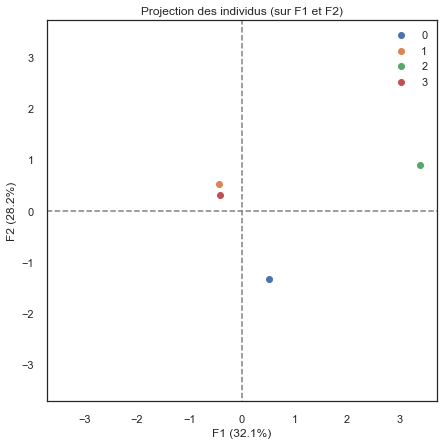

In [345]:
X_projectCentroide = pca_sugG.transform(pos_cent_sug)
display_factorial_planes(X_projectCentroide, n_comp, pca_sugG, [(0,1)], illustrative_var=df_gpe_sugG.cluster_sug.unique())
plt.show()

In [346]:
df_gpe_sugG[df_gpe_sugG['cluster_sug']==2]

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster_sug
pays,,,,,,
Argentine,24424.3,9.154596,3226.0,102.60,0.652339,2
Brunéi Darussalam,66714.5,18.079096,2985.0,93.29,0.567692,2
Estonie,29696.4,-3.883495,3248.0,103.65,0.513555,2
Allemagne,49873.1,-1.266291,3503.0,101.39,0.606470,2
Grèce,28077.4,0.870196,3394.0,108.65,0.545145,2
Kazakhstan,23720.8,11.479523,3262.0,96.35,0.592320,2
République de Corée,37060.6,5.732744,3333.0,96.12,0.479921,2
Malte,33596.4,4.126214,3374.0,110.31,0.559695,2
Nouvelle-Zélande,38990.6,12.061676,3136.0,92.39,0.593138,2


In [347]:
df_pos_cent_sug = pd.DataFrame(pos_cent_sug, index=df_gpe_sug_acpGpe.cluster_sug.unique(), 
                                 columns=['PIB_hab_dollars', 'diff_pop_pourcent', 'dispo_alim_T_kcal_hab_jr',
       'dispo_proteine_T_g_hab_jr', 'ratio_prot_ani_dispo_proteine_T'])

In [348]:
df_gpe_sug_acpGpe.head(2)

,pays,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T,cluster_sug
0,Argentine,24424.3,9.154596,3226.0,102.60,0.652339,2
1,Australie,47192.1,16.989926,3278.0,106.26,0.674666,3


In [349]:
df_centroSug = df_gpe_sug_acpGpe.groupby('cluster_sug').mean()
df_centroSug.head(4)

,PIB_hab_dollars,diff_pop_pourcent,dispo_alim_T_kcal_hab_jr,dispo_proteine_T_g_hab_jr,ratio_prot_ani_dispo_proteine_T
cluster_sug,,,,,
0,134427.000000,22.033562,3227.500000,104.195000,0.639745
1,47940.490000,15.789941,3616.800000,109.345000,0.545470
2,35885.452632,5.879042,3304.684211,99.985789,0.557229
3,42614.118182,6.491083,3289.090909,116.516364,0.662291


In [350]:
XcSug = df_centroSug.values
std_scalecSG = StandardScaler().fit(Xsug_pca)
X_scaledcSug = std_scalecSG.transform(XcSug)

In [351]:
X_scaledcSug

array([[ 3.64320382,  1.1530695 , -0.68528905, -0.25044874,  0.70392193],
       [ 0.11148363,  0.59347335,  1.17074659,  0.25554848, -0.52796647],
       [-0.38078989, -0.29480937, -0.31730383, -0.66401162, -0.37431649],
       [-0.10602145, -0.23995405, -0.39164682,  0.9601485 ,  0.99853037]])

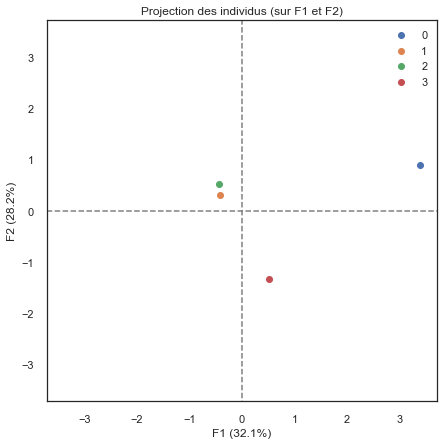

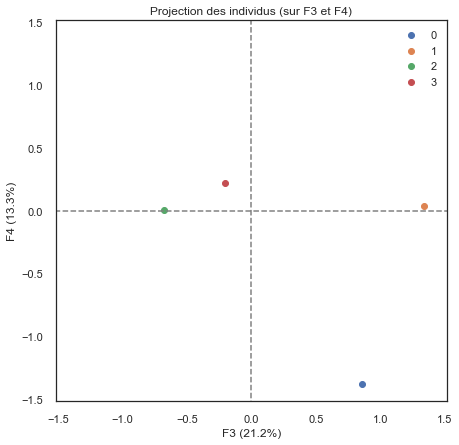

In [352]:
# Projection des nouveaux centroïdes
X_projected_SG = pca_sugG.transform(X_scaledcSug)
display_factorial_planes(X_projected_SG, n_comp, pca_sugG, [(0,1), (2,3)], illustrative_var=df_centroSug.index)
plt.show()

In [353]:
df_gpe_sugCl[df_gpe_sugCl['cluster_sug']==3]

,cluster_sug,pays
12,3,Islande
11,3,Chine - RAS de Hong-Kong
8,3,France
34,3,Suède
7,3,Finlande
19,3,Lituanie
5,3,Danemark
21,3,Maldives
1,3,Australie
28,3,Portugal
